In [894]:
import numpy as np
import matplotlib.pyplot as plt
#import galpak
#from galpak import DefaultModel, ModelSersic
import random

import os
import scipy as sc
import pandas as pd
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck15
from astropy.cosmology import WMAP9 as cosmo
from scipy.stats import binned_statistic
import matplotlib.backends.backend_pdf
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.optimize import minimize


import mpdaf
from mpdaf.obj import Cube
from mpdaf.drs import PixTable
#from galpak import MoffatPointSpreadFunction, GaussianLineSpreadFunction
from mpdaf.sdetect import Source

from astropy.io import fits 

import pymultinest

# the home made tool package:
import galpak_tools as gt

#import logistic
#import run_covering_2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [895]:
R = pd.read_csv("results_6_conservative.csv")

With visual inspections of the runs & catalogs we identified several bad runs that should not be taken into account:

In [896]:
bad_runs_ids = [11083, 12121, 23086, 23120, 26056, 26092, 29002, 29084, 28102, 30070, 30093, 31005]

- 17068 is suspect...
- 17078 must be rerun
- 20073 is quite bad even if snreff above 3
- 20074 is quite bad even if snreff above 3
- 20077 is quite bad even if snreff above 3
- 21107 no multinest? Rerun..
- 26092 no OII, no run
- 28102 no OII, no run
- 29002 mixed with QSO (bad cont or psf sub)
- 29084 other src nearby
- 30070 no OII (but snr = 10!)

In [897]:
fzlow_04 = R["Z"] > 0.4
fzlow_05 = R["Z"] > 0.5
fzhigh_15 = R["Z"] < 1.5
fzconf_0 = R["ZCONF"] > 0
fzconf_1 = R["ZCONF"] > 1
fnoQSO = R["is_QSO"] == 0
fnostar = R["is_star"] == 0

In [898]:
R_lowz = R[fzhigh_15 & fzconf_0 & fnoQSO & fnostar]
R_goodz_goodconf = R[fzlow_04 & fzhigh_15 & fzconf_1 & fnoQSO & fnostar]

print("Number of galaxies at z below 1.5 = ", len(R_lowz))
print("Number of galaxies at z below 1.5  and zconf= 2 or more = ", len(R_goodz_goodconf))

Number of galaxies at z below 1.5 =  1262
Number of galaxies at z below 1.5  and zconf= 2 or more =  960


# Study of the completeness

Text(0, 0.5, 'sed log(M*)')

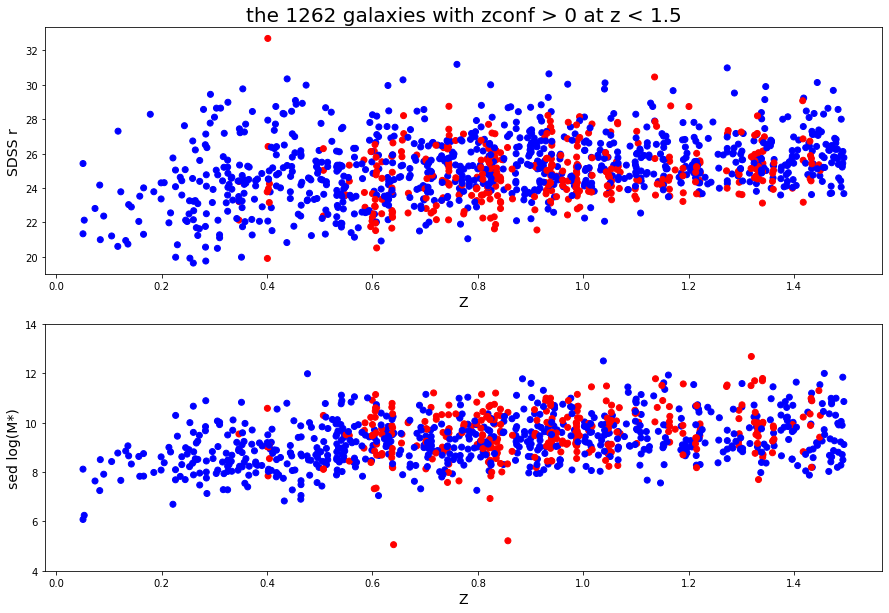

In [899]:
plt.figure(figsize = (15, 10))
plt.subplot(211)
plt.title("the "+ str(len(R_lowz))+ " galaxies with zconf > 0 at z < 1.5", size = 20)
plt.scatter(R_lowz["Z"], R_lowz["SDSS_r"], c = R_lowz["bool_absorption"], cmap = "bwr")
plt.xlabel("Z", size = 14)
plt.ylabel("SDSS r", size = 14)
plt.subplot(212)
plt.scatter(R_lowz["Z"], R_lowz["sed_logMass"], c = R_lowz["bool_absorption"], cmap = "bwr")
plt.ylim((4,14))
plt.xlabel("Z", size = 14)
plt.ylabel("sed log(M*)", size = 14)

Text(0.5, 0, 'logM')

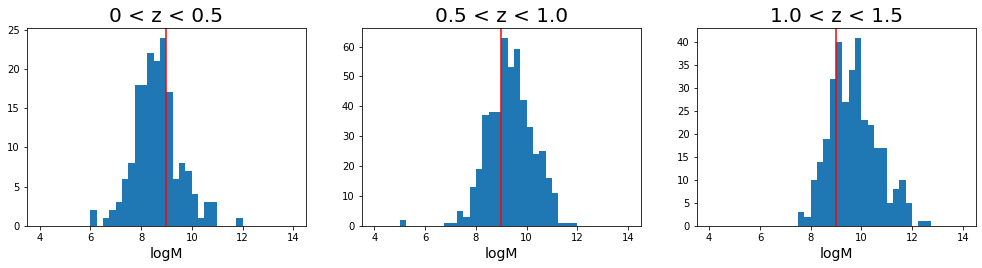

In [900]:
k_inf05 = R_lowz["Z"]<0.5
k_sup05 = R_lowz["Z"]>0.5
k_inf1 = R_lowz["Z"]<1
k_sup1 = R_lowz["Z"]>1

R0_05 = R_lowz[k_inf05]
R05_1 = R_lowz[k_sup05 & k_inf1]
R1_15 = R_lowz[k_sup1]


plt.figure(figsize = (17, 8))
plt.subplot(231)
plt.title("0 < z < 0.5", size = 20)
plt.hist(R0_05["sed_logMass"], range = (4,14), bins = 40)
plt.axvline(9, c = "r")
plt.xlabel("logM", size = 14)

plt.subplot(232)
plt.title("0.5 < z < 1.0", size = 20)
plt.hist(R05_1["sed_logMass"], range = (4,14), bins = 40)
plt.axvline(9, c = "r")
plt.xlabel("logM", size = 14)

plt.subplot(233)
plt.title("1.0 < z < 1.5", size = 20)
plt.hist(R1_15["sed_logMass"], range = (4,14), bins = 40)
plt.axvline(9, c = "r")
plt.xlabel("logM", size = 14)

So we are complete until 
- logM of ~ 8.5 at z < 0.5
- logM of ~ 9 at 0.5 < z < 1
- logM of ~ 9.5 at 1 < z < 1.5

Text(0.5, 0, 'SDSSr')

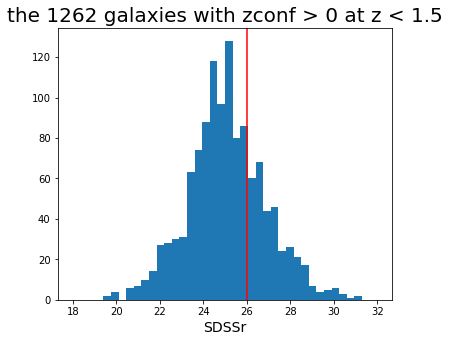

In [901]:
plt.figure(figsize = (6, 5))
plt.title("the "+ str(len(R_lowz))+ " galaxies with zconf > 0 at z < 1.5", size = 20)
plt.hist(R_lowz["SDSS_r"], range = (18,32), bins = 40)
plt.axvline(26, c = "r")
plt.xlabel("SDSSr", size = 14)


In [902]:
R_lowz_9sup = R_lowz[R_lowz["sed_logMass"]>= 9]
median_mass = np.median(R_lowz_9sup["sed_logMass"])
median_z = np.median(R_lowz_9sup["Z"])
print("The median mass of the galaxies with logM* > 9 is logM* = ", np.round(median_mass, 2))
print("The median redshift of the galaxies with logM* > 9 is z = ", np.round(median_z, 2))

The median mass of the galaxies with logM* > 9 is logM* =  9.79
The median redshift of the galaxies with logM* > 9 is z =  0.94


In [903]:
median_halo = gt.Behroozi(median_mass,median_z)
print("It correspond to a halo of logMh = ", np.round(median_halo,2))

It correspond to a halo of logMh =  11.67


# Size of the Fov vs size of DM halos

In [904]:
zz = np.linspace(0.4, 1.5, 20)
m11 = 10**(11)
m115 = 10**(11.5)
m12 = 10**(12)
m125 = 10**(12.5)
m13 = 10**(13)
r11 = gt.get_Rvir(m11, zz)
r115 = gt.get_Rvir(m115, zz)
r12 = gt.get_Rvir(m12, zz)
r125 = gt.get_Rvir(m125, zz)
r13 = gt.get_Rvir(m13, zz)

rr_fov = cosmo.kpc_proper_per_arcmin(zz)/2

Text(0, 0.5, 'kpc')

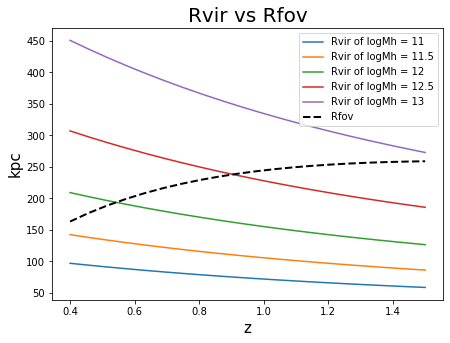

In [905]:
plt.figure(figsize = (7,5))
plt.title("Rvir vs Rfov", size = 20)
plt.plot(zz, r11, label = "Rvir of logMh = 11")
plt.plot(zz, r115, label = "Rvir of logMh = 11.5")
plt.plot(zz, r12, label = "Rvir of logMh = 12")
plt.plot(zz, r125, label = "Rvir of logMh = 12.5")
plt.plot(zz, r13, label = "Rvir of logMh = 13")

plt.plot(zz, rr_fov, label = "Rfov", c = "black", linewidth = 2, linestyle = "--")
plt.legend()
plt.xlabel("z", size = 15)
plt.ylabel("kpc", size = 15)

**So the size of the FOV is larger than Rvir of halos of logM < 12 down to low z of 0.5**

The conlusion of what we studied above is, first, that we can study galaxies of logM > 9 because we are complete until this mass. Second that we can look at isolated galaxies relatively to halo of size below logMh = 1e12 which is large enough. For more massive halos for inst 1e13 Msun, we would expect groups of galaxies, so galaxies would not be isolated anyway.

# Isolated galaxies

We Study galaxies with logM above 1e9 Msun. We define isolated galaxies as galaxies alone within an impact parameter corresponding to a given Rvir of a fixed halo mass of 1e12 (so it varies with z).

In [906]:
def isolated_auto_modif3(df, Mh = 1e12, b_sep = 30, dv = 1e6, group_threshold = 4, logm_sat = 9):
    R = df.copy()
    isol = []
    isol_dist = []
    Rfov = []
    
    for i, r in R.iterrows():
        p = 0
        b_max = gt.get_Rvir(Mh, r["Z"]).value
        
        # a galaxy can be primary only if within 100kpc
        if (r["sed_logMass"] > logm_sat) and (r["B_KPC"] < b_max) and (r["is_QSO"] == 0) and \
        (r["is_star"] == 0) and (r["Z"]< 1.5):
            # we then compute the number of neighbours within B + b_sep kpc:
            f1 = np.abs(R["Z"] - r["Z"])*const.c.value/(1+r["Z"])<dv
            f2 = R["field_id"] == r["field_id"]
            f3 = R["B_KPC"] <= r["B_KPC"] + b_sep
            f4 = R["B_KPC"] <= b_max
            f5 = R["sed_logMass"] > logm_sat
            Fbmax = R[f1 & f2 & f4 & f5]
            Fbsep = R[f1 & f2 & f3 & f5]
            
            # We don't consider galaxies in groups as primary:
            if r["N2000_LOS"] <= group_threshold:
                # to be primary, the galaxy must alone.. 
                if (len(Fbmax) == 1) & (len(Fbsep)==1):
                    p = 1
                # .. or the closest one (not taking into account satellites)
                else:
                    p = 0
        isol.append(p)
        isol_dist.append(b_max)
        Rfov.append((cosmo.kpc_proper_per_arcmin(r["Z"])/2).value)
        
    ISOL = np.array(isol)
    ISOL_DIST = np.array(isol_dist)
    RFOV = np.array(Rfov)

    R["isolated_auto"] = ISOL
    R["isolation_dist"] = ISOL_DIST
    R["Rfov"] = RFOV
    return R

We apply these isolation criteria to R_lowz in order to keep galaxies with ZCONF = 1. Indeed we want to be sure that isolated galaxies don't have potential neighbors (even ZCONF = 1 neighbors). We will select ZCONF > 1 galaxies afterward.

In [907]:
R_lowz = isolated_auto_modif3(R_lowz, Mh = 1e12, b_sep = 20, dv = 0.5e6, group_threshold = 4, logm_sat = 9)

In [908]:
R = R_lowz.copy()
print(len(R))

1262


There is one absorption associated with 2 isolated galaxies (which is problematic!) due to the fact that the Dv used for isolation is equal to the one for abs-gal association (it should be the double to be rigorous but we would then remove too many galaxies). The abs 128 is associated with 2 galaxies, but one is closer in B, in dv and is heavier so we consider that the other one is not associated with the absorption 

In [909]:
R.loc[R["ID"] == 14113, "bool_absorption"] = 0
R.loc[R["ID"] == 14113, "REW_2796"] = 0

In [910]:
f2 = R["N100_neighb"]<= 1
f100 = R["B_KPC"] <= 100
f150 = R["B_KPC"] <= 150
f200 = R["B_KPC"] <= 200
f4 = R["REW_2796"]>=0.3
f5 = R["REW_2796"]>=0.01
f6 = R["inclination_convergence"] == 1
f7 = R["pa_convergence"] == 1
f8 = R["snr_eff"]>=3
f9 = R["snr_eff"]>=10
f10 = R["inclination"] >= 40 
f11 = R["inclination"] >= 60
f12 = R["N100_abs"] == 1
f13 = R["N100_abs"] <= 2
f14 = R["bool_absorption"] == 1
f15 = R["N100_neighb"]<= 1
f16 = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 3000 #from Zabl 2019
f16b = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 1500 #from Zabl 2019
f17 = R["N50_neighb"]== 0
f18 = R["N50_neighb"]<= 1
f19 = R["alpha"] <= 40
f20 = R["is_QSO"] == 0
f21 = R["N2000_abs"] <= 4
f22 = R["is_closest"] == 1
f23 = R["B_KPC_NEIGHB"] >= 30
f24 = R["Z"] < 2
fzlow = R["Z"] > 0.4
fzhigh = R["Z"] < 1.5
fzconf_1 = R["ZCONF"] > 1
f25 = R["N2000_LOS"] <= 4
f26 = R["is_star"] == 0
f27_1 = R["alpha"] <= 33
f27_2 = (R["alpha"] >= 33) & (R["alpha"] <= 66)
f27_3 = R["alpha"] >= 66
f28 = R["inclination"] >= 35
#f29 = R["current"] == 1
f30 = R["isolated_auto"] == 1
f31 = R["primary_auto"] == 1
#f32 = R["galpak_score"] != 0
f33 = R["score_auto"] >= 1
f34 = R["score_auto"] >= 2
f35 = R["score_auto"] >= 3
f36 = R["sed_logMass"] >= 9
f37 = R["run_convergence_global"] >= 0.99
f38 = R["ID"].isin(bad_runs_ids)
f39 = R["sed_logMass"].isna()
f_SFR1 = np.log10(R["SFR_gilbank"]) >= 0
f_SFR01 = np.log10(R["SFR_gilbank"]) >= 0
f40 = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 300
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)

In [911]:
prim = R[f20 & f31]
R_9 = R[f20 & f100 & fzlow & fzhigh & fzconf_1 & fbehind & f36]
R100 = R[f20 & fzlow & fzhigh & fbehind & f100] 
R150 = R[f20 & fzlow & fzhigh & fbehind & f150]
R200 = R[f20 & fzlow & fzhigh & fbehind & f200]

isol = R[f20 & f30 & fbehind] #isolated galaxies
isol_abs = R[f20 & f30 & f14 & fbehind]
isol_noabs = R[f20 & f30 & ~f14 & fbehind]
isol_zconf = R[f20 & f30 & fzconf_1 & fbehind]
isol_zconf_abs = R[f20 & f30 & fzconf_1 & f14 & fbehind]
isol_zconf_noabs = R[f20 & f30 & fzconf_1 & ~f14 & fbehind]
isol_zselec = R[f20 &f30 & fzlow & fzhigh & fbehind] # isolated in z= 0.4 - 1.5
isol_zselec_mass = R[f20 & f30 & fzconf_1 & fzlow & fzhigh & fbehind & ~f39] 
isol_zselec_nomass = R[f20 & f30 & fzconf_1 & fzlow & fzhigh & fbehind & f39]
isol_zconf_1 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1
isol_9 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f14 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & ~f14 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_lowM = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* below 1e9
isol_lowM_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & f14 & fbehind]
isol_lowM_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & ~f14 & fbehind]
isol_9_convergence = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & fbehind] # idem with good convergence
isol_9_noconvergence = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & ~f37 & fbehind] # idem with good convergence
isol_lowM_convergence = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & f37 & fbehind]
isol_snr3 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & fbehind] # idem with good snr
isol_lowM_snr3 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & f37 & f8 & fbehind]
isol_good_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & fbehind] # good runs
isol_notgood_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f38 & fbehind]
isol_good_runs_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & f14 & fbehind] # good runs
isol_good_runs_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & ~f14 & fbehind] # good runs
isol_incl_good_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind] # good runs
isol_incl_good_runs_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & f14 & fbehind] # good runs
isol_incl_good_runs_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & ~f14 & fbehind] # good runs

isol_high_alpha = R[f20 & f10 & f27_3 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind]
isol_mid_alpha = R[f20 & f10 & f27_2 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind]
isol_low_alpha = R[f20 & f10 & f27_1 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind]

print("Number of galaxies with logM > 9, good z, QSO behind, good zconf = ", len(R_9))
print("Number of primaries = ", len(prim))
print("Number of isolated = ", len(isol))
print("Number of isolated with abs = ", len(isol_abs))
print("Number of distinct absorptions associated with isolated  = ", len(isol_abs["abs_id"].unique()))
print("Number of isolated with zconf >= 2 ", len(isol_zconf))
print("Number of isolated at 0.4 < z < 1.5 = ", len(isol_zselec))
print("Number of isolated at 0.4 < z < 1.5 and zconf >= 2 ", len(isol_zconf_1))
print("and with mass = ", len(isol_zselec_mass))
print("or without mass = ", len(isol_zselec_nomass))
print("with the previous filters on isolation, z, zconf and QSO behind:")
print("Number of isolated with logM > 9 = ", len(isol_9))
print("Number of isolated with logM > 9 and multinest run = ", len(isol_9[isol_9["run_name"] == "run_OII_multinest"]))
print("Number of isolated with logM > 9 with abs = ", len(isol_9_abs))
print("Number of isolated with logM > 9 without abs = ", len(isol_9_noabs))
print("Number of isolated with logM > 9 and good convergence = ", len(isol_9_convergence))
print("Number of isolated with logM > 9 and good convergence and snr_eff > 3  = ", len(isol_snr3))
print("Number of isolated with logM > 9 and good galpak runs  = ", len(isol_good_runs))
print("Number of isolated with logM > 9 and good galpak runs and incl>40 = ", len(isol_incl_good_runs))

Number of galaxies with logM > 9, good z, QSO behind, good zconf =  127
Number of primaries =  191
Number of isolated =  153
Number of isolated with abs =  44
Number of distinct absorptions associated with isolated  =  44
Number of isolated with zconf >= 2  140
Number of isolated at 0.4 < z < 1.5 =  132
Number of isolated at 0.4 < z < 1.5 and zconf >= 2  121
and with mass =  121
or without mass =  0
with the previous filters on isolation, z, zconf and QSO behind:
Number of isolated with logM > 9 =  121
Number of isolated with logM > 9 and multinest run =  119
Number of isolated with logM > 9 with abs =  43
Number of isolated with logM > 9 without abs =  78
Number of isolated with logM > 9 and good convergence =  119
Number of isolated with logM > 9 and good convergence and snr_eff > 3  =  91
Number of isolated with logM > 9 and good galpak runs  =  82
Number of isolated with logM > 9 and good galpak runs and incl>40 =  58


We have 2 galaxies of logM above 9 but no multinest run. After inspection, it is because there is no OII:

In [912]:
K = isol_9[isol_9["run_name"] != "run_OII_multinest"]
K[["field_id", "ID", "run_name"]]

,field_id,ID,run_name
65,J0014m0028,11083,NaN
1480,J1314p0657,26092,NaN


In [913]:
R_all = pd.read_csv("results_6_conservative.csv")
R_all["ZCONF"].unique()

array([3, 2, 1])

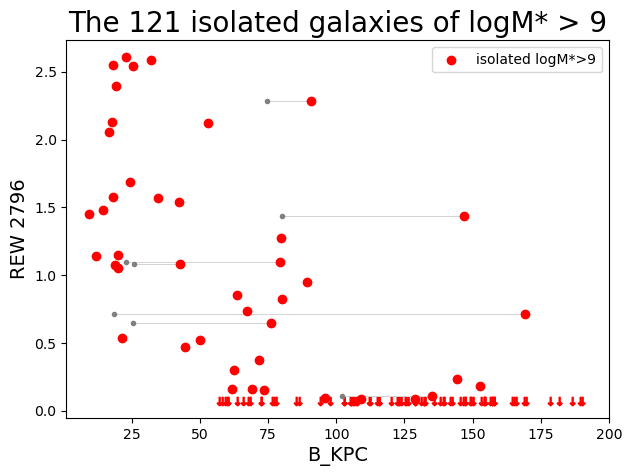

In [914]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'r',\
                 label = "isolated logM*>9", zorder = 2)

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "r",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

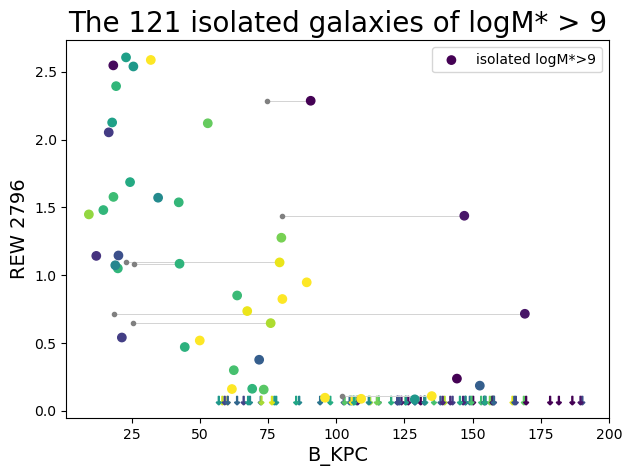

In [932]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"],\
                c = np.log10(isol_9_abs["SFR_gilbank"]), vmin = -0.5, vmax = 1.2,
                 laabel = "isolated logM*>9", zorder = 2)

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"],\
            c = np.log10(isol_9_noabs["SFR_gilbank"]), vmin = -0.5, vmax = 1.2,
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

- faire catalogue + inspecter les 121
- afficher clairement accretions vs vents
- essayer de normaliser par sin(i) pour les vents
- regarder l'impact du SFR
- faire un random forest
- faire aussi les galaxies primaires de façon rigoureuse comme je viens de faire les galaxies isolées.

## Alpha dependence

For that we must only use the galaxies with good runs (82) and sufficient inclination to obtain a robust alpha. The 121 galaxies are then reduced to 58.

In [915]:
len(isol_good_runs)

82

Text(0, 0.5, 'REW 2796')

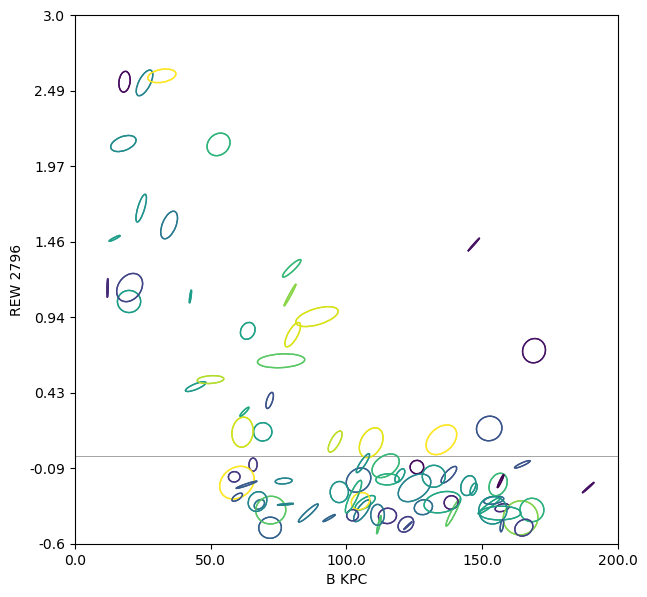

In [916]:
fig = plt.figure(figsize = (7,7), dpi = 100)
#plt.scatter(isol_abs["B_KPC"], isol_abs["REW_2796"], c = "blue", label = "all")
#plt.scatter(isol_noabs["B_KPC"], isol_noabs["detection_limit_p75"],c = "blue", marker = "$\downarrow$")

ymin = -0.6
ymax = 3.
xmin = 0
xmax = 200
massmin = 9
massmax = 12
ss_min = 0.02
ss_max = 0.1
vmin = -0.5
vmax = 1.5

for i, g in isol_good_runs.iterrows():
    xx = (g["B_KPC"] - xmin)/(xmax - xmin)
    yy = (g["REW_2796"] - ymin)/(ymax - ymin)
    if g["REW_2796"] == 0:
        randy = random.uniform(-0.5, -0.05)
        yy = (randy - ymin)/(ymax - ymin)
    
    mass = g["sed_logMass"]
    incl = g["inclination"]
    alpha = g["alpha"]
    logSFR = np.log10(g["SFR_gilbank"])
    z = g["Z"]
    
    p = (mass - massmin)/(massmax - massmin)
    ss = p*(ss_max - ss_min) + ss_min
    w = ss
    h = ss*np.cos(incl*2*np.pi/360)
    
    if np.isnan(g["inclination"]) == False:    
        ellipse = matplotlib.patches.Ellipse(xy=(xx, yy), width=w, height=h, angle=alpha,\
                        edgecolor = plt.cm.viridis((logSFR - vmin) / (vmax - vmin)), fill = False)
        fig.patches.append(ellipse)
        fig.gca().add_patch(ellipse)
    else:
        plt.scatter(xx, yy)
    
#plotting the 0 line
plt.axhline(-ymin/(ymax - ymin), c = "gray", linewidth = 0.5)

# Now for the axis:
step = 5
xdata = np.linspace(0, 1, 5)
xvalues = np.linspace(xmin, xmax, 5)
ydata = np.linspace(0,1, 8)
yvalues = np.round(np.linspace(ymin, ymax, 8),2)
    
plt.xlim((0, 1))
plt.ylim((0, 1))
# Set custom tick values for the x-axis
plt.xticks(xdata, xvalues)
plt.yticks(ydata, yvalues)

plt.xlabel("B KPC")
plt.ylabel("REW 2796")

Text(0.5, 0, 'b [kpc]')

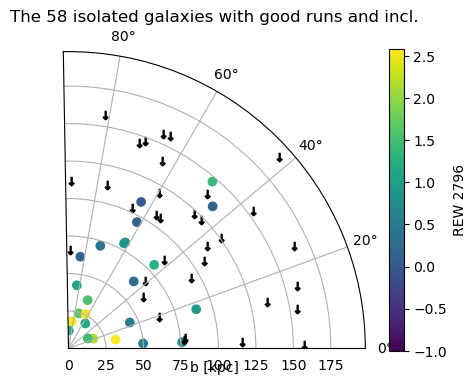

In [917]:
fig = plt.figure(dpi = 100)
ax = fig.add_subplot(projection='polar')
ax.set_title("The "+ str(len(isol_incl_good_runs)) + " isolated galaxies with good runs and incl.", size = 12)

c = ax.scatter(isol_incl_good_runs_abs["alpha"]*2*np.pi/360, isol_incl_good_runs_abs["B_KPC"], \
               c = isol_incl_good_runs_abs["REW_2796"], vmin = -1)
fig.colorbar(c, label = "REW 2796")
c2 = ax.scatter(isol_incl_good_runs_noabs["alpha"]*2*np.pi/360, isol_incl_good_runs_noabs["B_KPC"], \
                marker = "$\downarrow$", c = "black")
plt.xlim((0,91*2*np.pi/360))
plt.xlabel("b [kpc]")

Text(0.5, 0, 'b [kpc]')

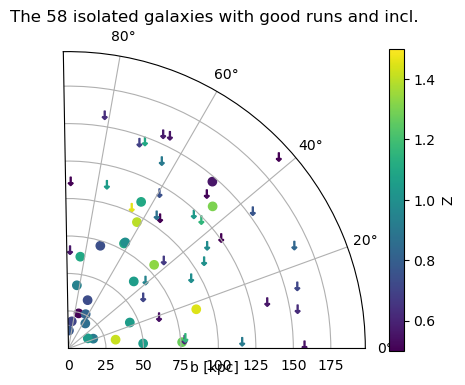

In [918]:
fig = plt.figure(dpi = 100)
ax = fig.add_subplot(projection='polar')
ax.set_title("The "+ str(len(isol_incl_good_runs)) + " isolated galaxies with good runs and incl.", size = 12)

c = ax.scatter(isol_incl_good_runs_abs["alpha"]*2*np.pi/360, isol_incl_good_runs_abs["B_KPC"], \
               c = isol_incl_good_runs_abs["Z"], vmin = 0.5, vmax = 1.5)
fig.colorbar(c, label = "Z")
c2 = ax.scatter(isol_incl_good_runs_noabs["alpha"]*2*np.pi/360, isol_incl_good_runs_noabs["B_KPC"], \
                marker = "$\downarrow$", c = isol_incl_good_runs_noabs["Z"], vmin = 0.5, vmax = 1.5)
plt.xlim((0,91*2*np.pi/360))
plt.xlabel("b [kpc]")

Text(0.5, 0, 'b [kpc]')

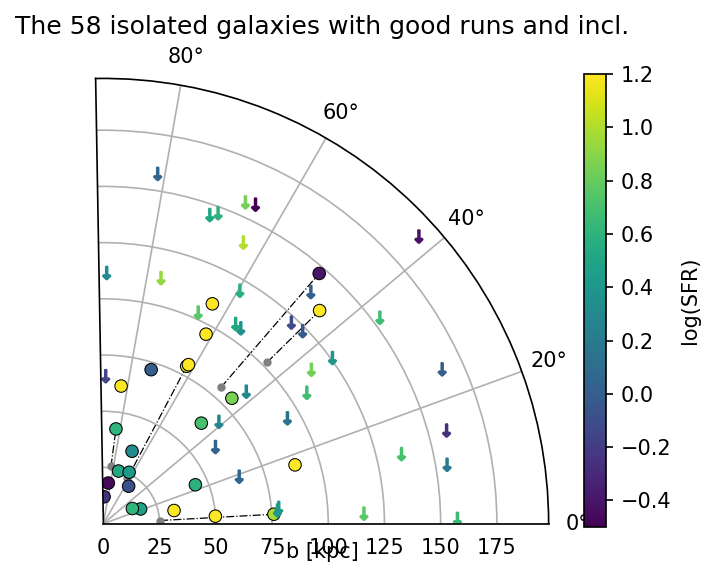

In [950]:
fig = plt.figure(dpi = 150)
ax = fig.add_subplot(projection='polar')
ax.set_title("The "+ str(len(isol_incl_good_runs)) + " isolated galaxies with good runs and incl.", size = 12)
for i, g in isol_incl_good_runs_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    gmin = K[K["B_KPC"] == bmin]
    angle = g["alpha"]*2*np.pi/360
    plt.plot([angle, angle], [bmin, bmax], color = "black", linewidth = 0.6, linestyle = "-.", zorder = 1)
    plt.scatter(angle, bmin, marker = ".", c = "grey", zorder = 2)
    
    
c = ax.scatter(isol_incl_good_runs_abs["alpha"]*2*np.pi/360, isol_incl_good_runs_abs["B_KPC"], \
               c = np.log10(isol_incl_good_runs_abs["SFR_gilbank"]), vmin = -0.5, vmax = 1.2, zorder = 2,\
              edgecolor = "black", linewidths = 0.5)
#              s = (isol_incl_good_runs_abs["sed_logMass"]-9)*100)
fig.colorbar(c, label = "log(SFR)")
c2 = ax.scatter(isol_incl_good_runs_noabs["alpha"]*2*np.pi/360, isol_incl_good_runs_noabs["B_KPC"], \
                marker = "$\downarrow$", \
                c = np.log10(isol_incl_good_runs_noabs["SFR_gilbank"]), vmin = -0.5, vmax = 1.2, zorder = 2)
plt.xlim((0,91*2*np.pi/360))
plt.xlabel("b [kpc]")

**We have a bit more absorption cases at high alpha. But it seems to play a minor role in the presence and strength of absorption nonetheless**. Between 20 and 40° there are several cases of low B and no abs.

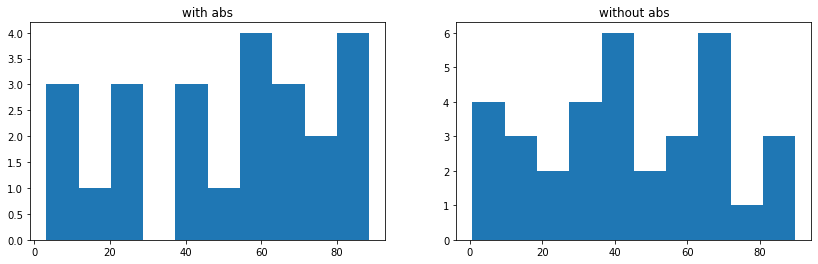

In [387]:
plt.figure(figsize = (14, 4))
plt.subplot(121)
plt.title("with abs")
plt.hist(isol_incl_good_runs_abs["alpha"]);
plt.subplot(122)
plt.title("without abs")
plt.hist(isol_incl_good_runs_noabs["alpha"]);

In [262]:
print("Out of the ", len(R100), "galaxies with ZCONF > 0 in 100 kpc, ", \
      len(R100[R100["run_name"] == "run_OII_multinest"]), " have a multinest run")
print("Out of the ", len(R150), "galaxies with ZCONF > 0 in 150 kpc, ", \
      len(R150[R150["run_name"] == "run_OII_multinest"]), " have a multinest run")
print("Out of the ", len(R200), "galaxies with ZCONF > 0 in 200 kpc, ", \
      len(R200[R200["run_name"] == "run_OII_multinest"]), " have a multinest run")

Out of the  227 galaxies with ZCONF > 0 in 100 kpc,  202  have a multinest run
Out of the  420 galaxies with ZCONF > 0 in 150 kpc,  386  have a multinest run
Out of the  671 galaxies with ZCONF > 0 in 200 kpc,  407  have a multinest run


In [263]:
input_path = "/muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/"
output_path = "/muse/MG2QSO/private/analysis/galpak_dr2/"
#gt.build_catalog(isol_9, output_path, output_path, file_name = "isolated_catalog_2023_10_18")

In [264]:
#gt.substract_continuum_on_ids(R150, input_path, output_path, snr_min = 0, line = "OII")

In [265]:
#gt.run_galpak_on_ids(input_path, output_path, R150, snr_min = 0.5, mag_sdss_r_max = 28,\
#                   flux_profile = "sersic", rotation_curve = "Salucci",autorun = False, mcmc_method = "multinest",\
#                   save = True, line = "OII", overwrite = False, suffix = "multinest")

Logically we should see (at least for the winds) a relation between the inclination and the velocity difference with the absorption.

In [396]:
winds = isol_incl_good_runs[isol_incl_good_runs["alpha"] > 66]
accretions = isol_incl_good_runs[isol_incl_good_runs["alpha"] < 33]

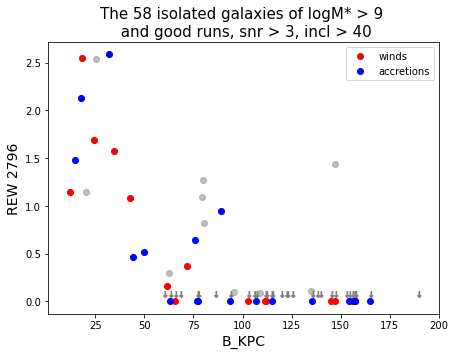

In [400]:
plt.figure(figsize = (7, 5))
plt.title("The " + str(len(isol_incl_good_runs)) + \
          " isolated galaxies of logM* > 9 \n and good runs, snr > 3, incl > 40",\
          size = 15)

plt.scatter(isol_incl_good_runs_abs["B_KPC"], isol_incl_good_runs_abs["REW_2796"], c = "gray",\
                 alpha = 0.5)
plt.scatter(isol_incl_good_runs_noabs["B_KPC"], isol_incl_good_runs_noabs["detection_limit_p75"], c = "gray",\
             marker = "$\downarrow$")

plt.scatter(winds["B_KPC"], winds["REW_2796"], c = "r", label = "winds")

plt.scatter(accretions["B_KPC"], accretions["REW_2796"], c = "b", label = "accretions")

#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

In [268]:
winds_abs = winds[winds["bool_absorption"] == 1]
accretions_abs = accretions[accretions["bool_absorption"] == 1]

Text(0, 0.5, 'Dv abs')

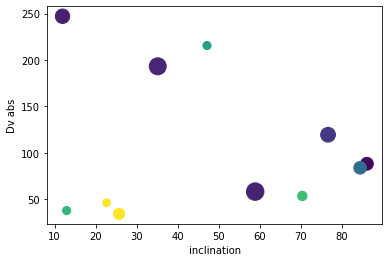

In [405]:
plt.scatter(winds_abs["inclination"], winds_abs["vel_absorption_dist"]/1e3, \
            c = winds_abs["B_KPC"], vmin = 10, vmax = 100, s = winds_abs["REW_2796"]*100+50)
plt.xlabel("inclination")
plt.ylabel("Dv abs")

Text(0, 0.5, 'Dv abs')

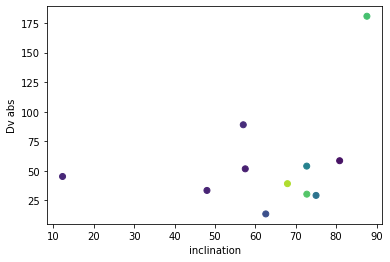

In [402]:
plt.scatter(accretions_abs["inclination"], accretions_abs["vel_absorption_dist"]/1e3, \
           c = accretions_abs["B_KPC"], vmin = 10, vmax = 100)
plt.xlabel("inclination")
plt.ylabel("Dv abs")

In [271]:
isol_good_runs_multinest = isol_good_runs.copy()

# Random Forest = what are the determining parameters??

In [820]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Johannes did the job with the following parameters: ['Z', 'B_KPC', 'sed_logMass', 'max_mass_win', 'n_gal_win', 'logOIIsfr', 'max_logOIIsfr_win', 'logOIIssfr', 'max_logOIIssfr_win']

The parameters that could have an impact according to me are:
- Z
- B kpc
- sed_logMass
- max_mass_win
- N_gal_win (in isolation radius)
- logSFR
- max_logSFR_win
- logSSFR
- max_logSSFR
- alpha
- mass_closest_gal_win

We now have to build these parameters

In [880]:
R = pd.read_csv("results_6_conservative.csv")

R['sed_logMass'] = R['sed_logMass'].fillna(6)
R.loc[R['sed_logMass'] < 1, 'sed_logMass'] = 6 # because we have some galaxy with sed_logMass = -21
R["logSFR"] = np.log10(R["SFR_gilbank"])
R["logSSFR"] = np.log10(R["SFR_gilbank"]/R["sed_logMass"])
R['logSFR'] = R['logSFR'].fillna(-2)
R['logSSFR'] = R['logSSFR'].fillna(-5)

In [881]:
fzlow_04 = R["Z"] > 0.4
fzlow_05 = R["Z"] > 0.5
fzhigh_15 = R["Z"] < 1.5
fzconf_0 = R["ZCONF"] > 0
fzconf_1 = R["ZCONF"] > 1
fnoQSO = R["is_QSO"] == 0
fnostar = R["is_star"] == 0
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)

In [882]:
R_goodz = R[fzlow_05 & fzhigh_15 & fzconf_0 & fnoQSO & fnostar & fbehind]
print("Number of galaxies at z below 1.5 = ", len(R_goodz))

Number of galaxies at z below 1.5 =  972


For the "window" parameter we use the full catalog in order to keep any potential neihbour rather than just neighbour from the same sample (for ex with logM above 9)

In [883]:
def build_RF_param(df, Rall, Mh = 1e12, dv = 1e6):
    R = df.copy()
    Nlos = []
    isol_dist = []
    Rfov = []
    max_mass_win = []
    n_gal_win = []
    max_logSFR_win = []
    max_logSSFR_win = []
    B_heaviest = []
    B_closest = []
    mass_closest = []
    #print(len(Rall[Rall["sed_logMass"].isna()]))
    
    for i, r in R.iterrows():
        b_max = gt.get_Rvir(Mh, r["Z"]).value
        
        # we then compute the number of neighbours within B + b_sep kpc:
        f1 = np.abs(Rall["Z"] - r["Z"])*const.c.value/(1+r["Z"])<dv
        f2 = Rall["field_id"] == r["field_id"]
        f4 = Rall["B_KPC"] <= b_max
        #Fbmax = Rall[f1 & f2 & f4]
        Fbmax = Rall[f1 & f2]
        smallest_b = np.min(Fbmax["B_KPC"])
        max_mass = np.max(Fbmax["sed_logMass"])
        heaviest = Fbmax[Fbmax["sed_logMass"] == max_mass]
        closest_gal = Fbmax[Fbmax["B_KPC"] == smallest_b]
        #print(np.max(Fbmax["sed_logMass"]))
        
        max_mass_win.append(np.max(Fbmax["sed_logMass"]))
        n_gal_win.append(len(Fbmax["sed_logMass"]))
        max_logSFR_win.append(np.max(Fbmax["logSFR"]))
        max_logSSFR_win.append(np.max(Fbmax["logSSFR"]))
        mass_closest.append(np.max(closest_gal["sed_logMass"]))
        B_closest.append(smallest_b)
        B_heaviest.append(heaviest.iloc[0]["B_KPC"])

        
    
    ISOL_DIST = np.array(isol_dist)
    RFOV = np.array(Rfov)

    R["max_mass_win"] = np.array(max_mass_win)
    R["n_gal_win"] = np.array(n_gal_win)
    R["max_logSFR_win"] = np.array(max_logSFR_win)
    R["max_logSSFR_win"] = np.array(max_logSSFR_win)
    R["B_closest"] = np.array(B_closest)
    R["B_heaviest"] = np.array(B_heaviest)
    R["mass_closest"] = np.array(mass_closest)
    return R

In [884]:
R_RF = build_RF_param(R_goodz, R, Mh = 1e12, dv = 0.5e6)

In [885]:
print(len(R_RF))

R_RF_X = R_RF[["Z", "B_KPC", "sed_logMass", "logSFR", "logSSFR", "n_gal_win", "max_mass_win", "max_logSFR_win", \
             "max_logSSFR_win", "B_closest", "mass_closest", "B_heaviest"]]
R_RF_Y = R_RF[["bool_absorption"]]

972


In [886]:
random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(R_RF_X, R_RF_Y)

/tmp/ipykernel_3257939/3163715387.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(R_RF_X, R_RF_Y)


RandomForestClassifier(n_estimators=500)

Text(0, 0.5, 'feature importance')

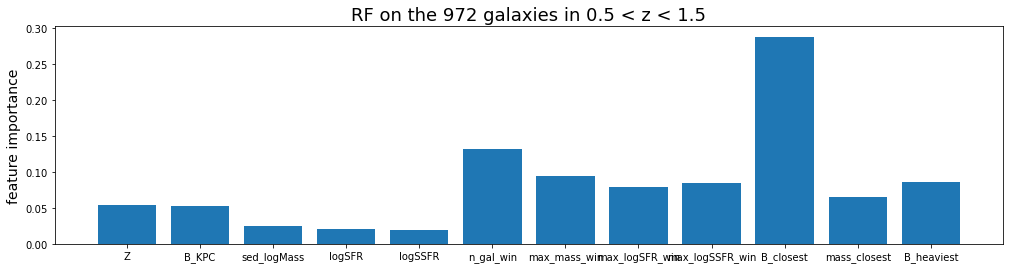

In [887]:
plt.figure(figsize = (17,4))
plt.title("RF on the "+str(len(R_RF))+" galaxies in 0.5 < z < 1.5", size = 18)
plt.bar(range(len(R_RF_X.columns)), random_forest.feature_importances_, tick_label = R_RF_X.columns)
plt.ylabel("feature importance", size = 14)

### For isolated galaxies

In [888]:
isol_9['sed_logMass'] = isol_9['sed_logMass'].fillna(6)
isol_9.loc[isol_9['sed_logMass'] < 1, 'sed_logMass'] = 6 # because we have some galaxy with sed_logMass = -21
isol_9["logSFR"] = np.log10(isol_9["SFR_gilbank"])
isol_9["logSSFR"] = np.log10(isol_9["SFR_gilbank"]/isol_9["sed_logMass"])
isol_9['logSFR'] = isol_9['logSFR'].fillna(-2)
isol_9['logSSFR'] = isol_9['logSSFR'].fillna(-5)

In [868]:
R_RF2 = build_RF_param(isol_9, R, Mh = 1e12, dv = 0.5e6)
print(len(R_RF2))
R_RF2_X = R_RF2[["Z", "B_KPC", "sed_logMass", "logSFR", "logSSFR", "n_gal_win", "max_mass_win", "max_logSFR_win", \
             "max_logSSFR_win", "B_closest", "mass_closest", "B_heaviest"]]
R_RF2_Y = R_RF2[["bool_absorption"]]

121

In [870]:
random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(R_RF2_X, R_RF2_Y)

/tmp/ipykernel_3257939/2846893727.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(R_RF2_X, R_RF2_Y)


RandomForestClassifier(n_estimators=500)

Text(0, 0.5, 'feature importance')

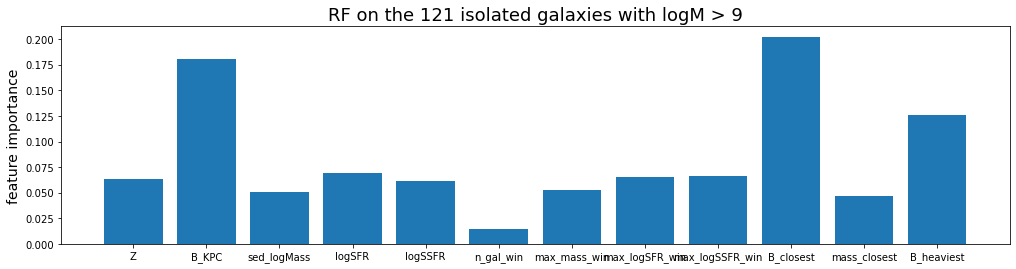

In [871]:
plt.figure(figsize = (17,4))
plt.title("RF on the "+str(len(R_RF2))+" isolated galaxies with logM > 9", size = 18)
plt.bar(range(len(R_RF2_X.columns)), random_forest.feature_importances_, tick_label = R_RF2_X.columns)
plt.ylabel("feature importance", size = 14)

### For isolated galaxies with good incl and alpha

In [872]:
isol_incl_good_runs['sed_logMass'] = isol_incl_good_runs['sed_logMass'].fillna(6)
isol_incl_good_runs.loc[isol_incl_good_runs['sed_logMass'] < 1, 'sed_logMass'] = 6 # because we have some galaxy with sed_logMass = -21
isol_incl_good_runs["logSFR"] = np.log10(isol_incl_good_runs["SFR_gilbank"])
isol_incl_good_runs["logSSFR"] = np.log10(isol_incl_good_runs["SFR_gilbank"]/isol_incl_good_runs["sed_logMass"])
isol_incl_good_runs['logSFR'] = isol_incl_good_runs['logSFR'].fillna(-2)
isol_incl_good_runs['logSSFR'] = isol_incl_good_runs['logSSFR'].fillna(-5)

In [875]:
R_RF3 = build_RF_param(isol_incl_good_runs, R, Mh = 1e12, dv = 0.5e6)

print(len(R_RF3))

R_RF3_X = R_RF3[["Z", "B_KPC", "sed_logMass", "logSFR", "logSSFR", "n_gal_win", "max_mass_win", "max_logSFR_win", \
             "max_logSSFR_win", "B_closest", "mass_closest", "B_heaviest"]]
R_RF3_Y = R_RF3[["bool_absorption"]]

58


In [876]:
random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(R_RF3_X, R_RF3_Y)

/tmp/ipykernel_3257939/3718472198.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(R_RF3_X, R_RF3_Y)


RandomForestClassifier(n_estimators=500)

/tmp/ipykernel_3257939/1527700499.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(R_RF3_X, R_RF3_Y)


Text(0, 0.5, 'feature importance')

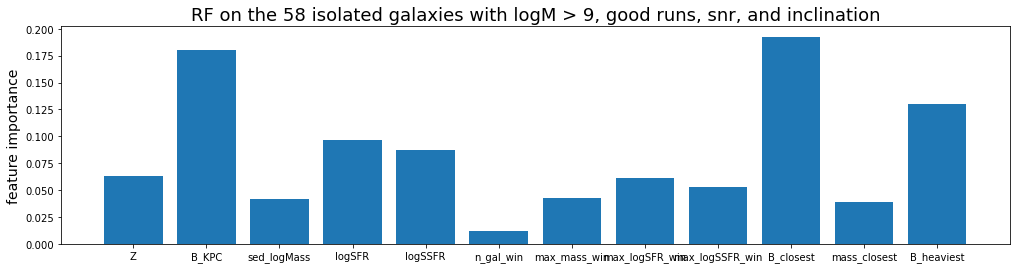

In [877]:
random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(R_RF3_X, R_RF3_Y)
#print(R_RF3_X.columns)
#print(random_forest.feature_importances_)
plt.figure(figsize = (17,4))
plt.title("RF on the "+str(len(R_RF3))+" isolated galaxies with logM > 9, good runs, snr, and inclination", size = 18)
plt.bar(range(len(R_RF3_X.columns)), random_forest.feature_importances_, tick_label = R_RF3_X.columns)
plt.ylabel("feature importance", size = 14)

So we obtain similar results. Now if we add the alpha parameter:

In [957]:
def f(x):
    return -np.abs(x - 45) + 45

In [974]:
R_RF3["alpha_modif"] = f(R_RF3["alpha"]) # get the alpha in 0 - 45. If alpha = 90 it goes to 0, if 65 it goes to 25.

R_RF3["orientation"] = 1 #an alternative method is to use a flag. 0 = accretion, 1 = middle, 2 = wind.
R_RF3.loc[R_RF3["alpha"] < 33, "orientation"] = 0
R_RF3.loc[R_RF3["alpha"] > 66, "orientation"] = 2

R_RF3_X = R_RF3[["Z", "B_KPC", "sed_logMass", "logSFR", "logSSFR", "orientation", "n_gal_win", "max_mass_win", \
                 "max_logSFR_win","max_logSSFR_win", "B_closest", "mass_closest", "B_heaviest"]]
R_RF3_Y = R_RF3[["bool_absorption"]]

/tmp/ipykernel_3257939/1527700499.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(R_RF3_X, R_RF3_Y)


Text(0, 0.5, 'feature importance')

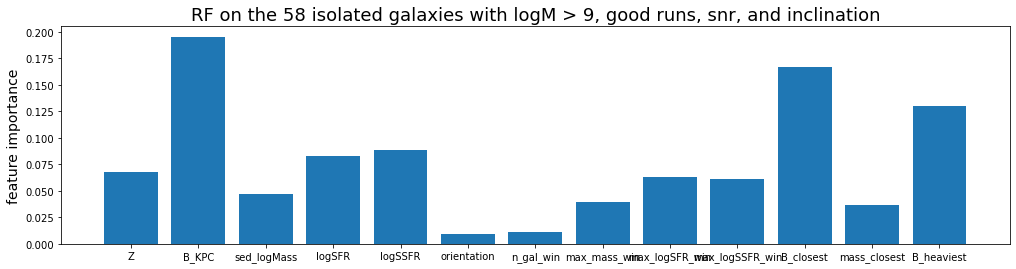

In [976]:
random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(R_RF3_X, R_RF3_Y)
#print(R_RF3_X.columns)
#print(random_forest.feature_importances_)
plt.figure(figsize = (17,4))
plt.title("RF on the "+str(len(R_RF3))+" isolated galaxies with logM > 9, good runs, snr, and inclination", size = 18)
plt.bar(range(len(R_RF3_X.columns)), random_forest.feature_importances_, tick_label = R_RF3_X.columns)
plt.ylabel("feature importance", size = 14)

/tmp/ipykernel_3257939/1527700499.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(R_RF3_X, R_RF3_Y)


Text(0, 0.5, 'feature importance')

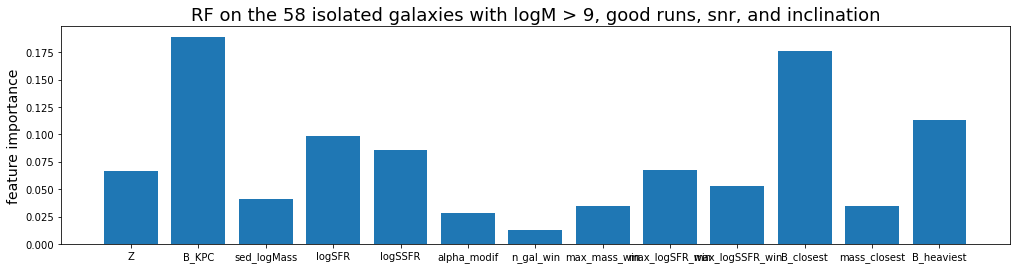

In [969]:
random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(R_RF3_X, R_RF3_Y)
#print(R_RF3_X.columns)
#print(random_forest.feature_importances_)
plt.figure(figsize = (17,4))
plt.title("RF on the "+str(len(R_RF3))+" isolated galaxies with logM > 9, good runs, snr, and inclination", size = 18)
plt.bar(range(len(R_RF3_X.columns)), random_forest.feature_importances_, tick_label = R_RF3_X.columns)
plt.ylabel("feature importance", size = 14)

/tmp/ipykernel_3257939/1527700499.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(R_RF3_X, R_RF3_Y)


Text(0, 0.5, 'feature importance')

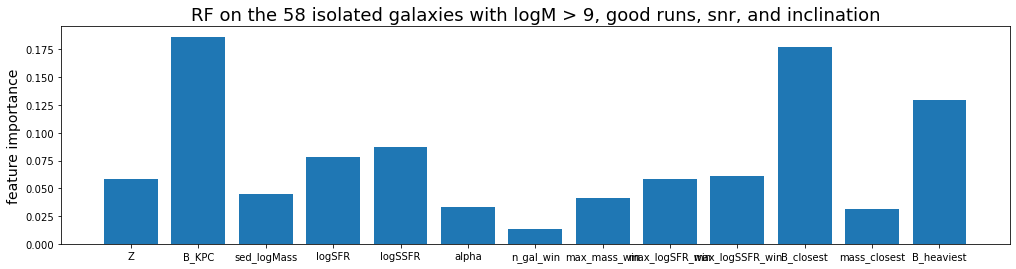

In [892]:
random_forest = RandomForestClassifier(n_estimators=500)
random_forest.fit(R_RF3_X, R_RF3_Y)
#print(R_RF3_X.columns)
#print(random_forest.feature_importances_)
plt.figure(figsize = (17,4))
plt.title("RF on the "+str(len(R_RF3))+" isolated galaxies with logM > 9, good runs, snr, and inclination", size = 18)
plt.bar(range(len(R_RF3_X.columns)), random_forest.feature_importances_, tick_label = R_RF3_X.columns)
plt.ylabel("feature importance", size = 14)

So with that test we obtain that alpha is of very low importance. Lower than Z, SFR or the mass of the closest galaxy.

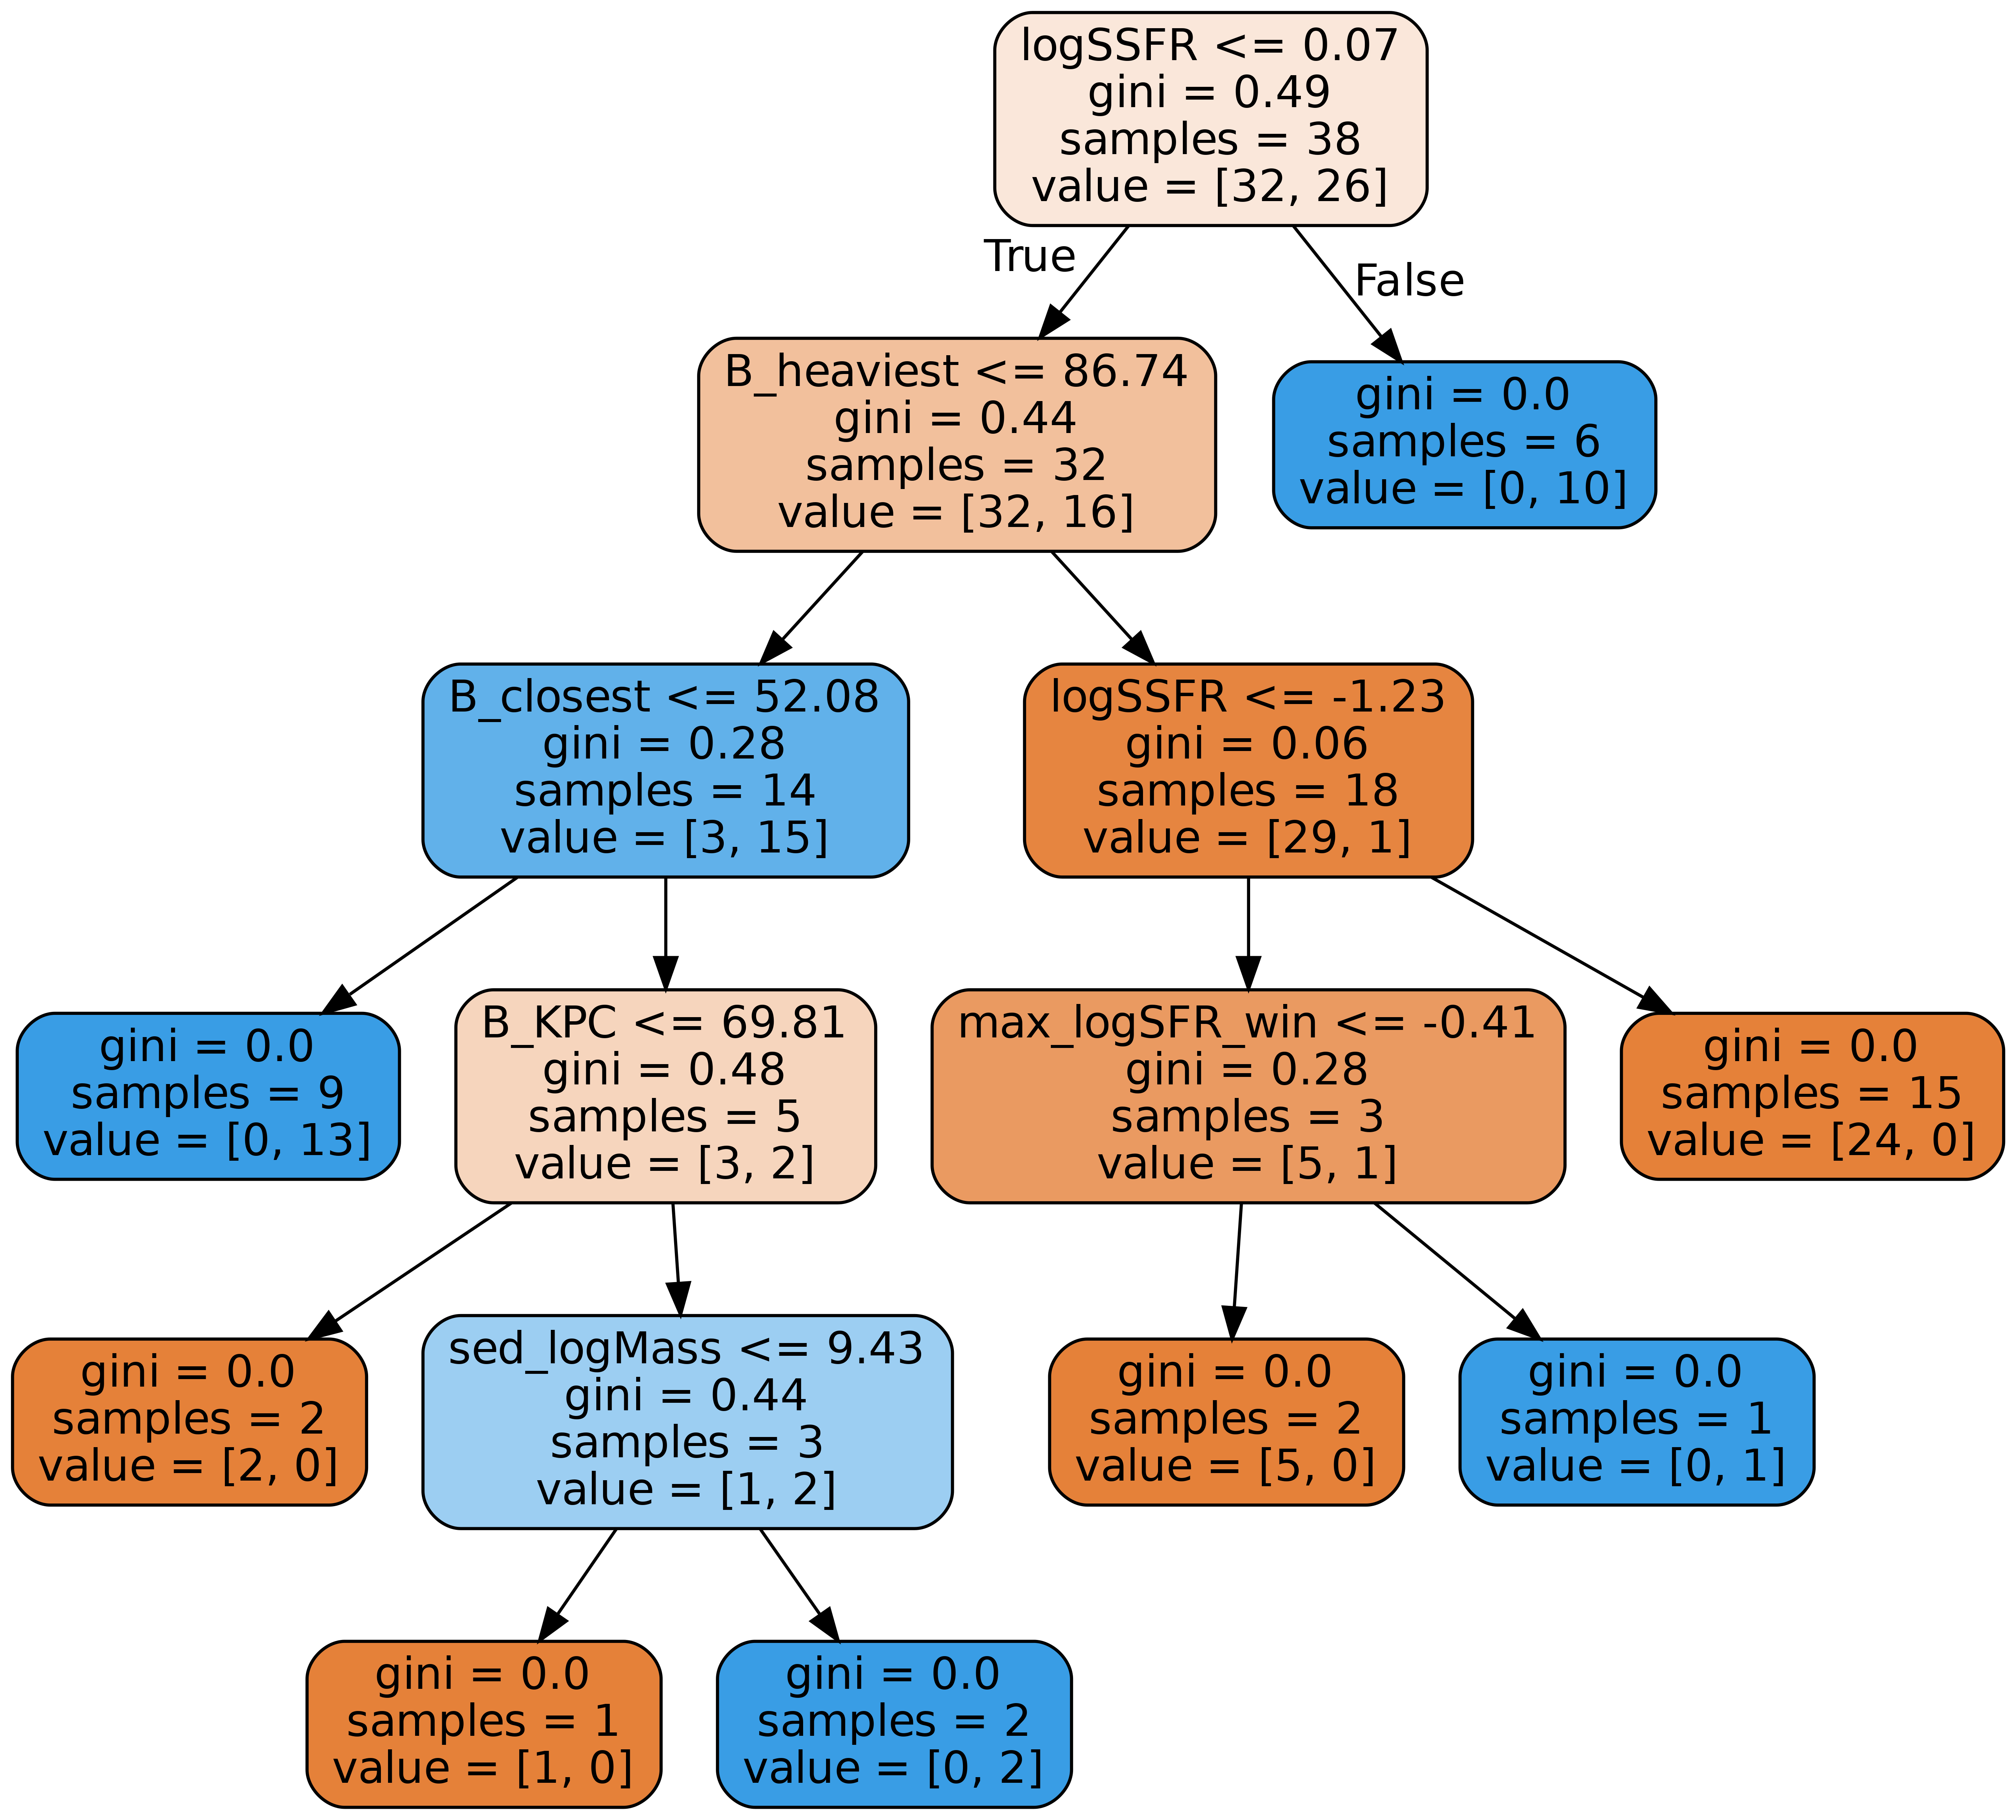

In [893]:
estimator = random_forest.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot',
                feature_names = ["Z", "B_KPC", "sed_logMass", "logSFR", "logSSFR", "alpha", "n_gal_win", "max_mass_win", \
                 "max_logSFR_win","max_logSSFR_win", "B_closest", "mass_closest", "B_heaviest"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
    
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

# Non isolated galaxies

Here we try to have a similar rigorous approach but for the cases where we have more galaxies in the FOV (up to 5) of logM above 9. This is tricky, specially to take into account satellites etc.

In [26]:
def isolated_auto_modif4(df, Mh = 1e12, b_sep = 30, dv = 1e6, group_threshold = 4, logm_sat = 9):
    R = df.copy()
    Nlos = []
    isol_dist = []
    Rfov = []
    
    for i, r in R.iterrows():
        p = 0
        b_max = gt.get_Rvir(Mh, r["Z"]).value
        
        # a galaxy can be primary only if within 100kpc
        if (r["sed_logMass"] > logm_sat) and (r["B_KPC"] < b_max) and (r["is_QSO"] == 0) and \
        (r["is_star"] == 0) and (r["Z"]< 1.5):
            # we then compute the number of neighbours within B + b_sep kpc:
            f1 = np.abs(R["Z"] - r["Z"])*const.c.value/(1+r["Z"])<dv
            f2 = R["field_id"] == r["field_id"]
            f3 = R["B_KPC"] <= r["B_KPC"] + b_sep
            f4 = R["B_KPC"] <= b_max
            f5 = R["sed_logMass"] > logm_sat
            Fbmax = R[f1 & f2 & f4 & f5]
            Fbsep = R[f1 & f2 & f3 & f5]
            
            # We don't consider galaxies in groups as primary:
            #if r["N2000_LOS"] <= group_threshold:
                # to be primary, the galaxy must alone.. 
            p = len(Fbmax)
            
        Nlos.append(p)
        isol_dist.append(b_max)
        Rfov.append((cosmo.kpc_proper_per_arcmin(r["Z"])/2).value)
        
    NLOS = np.array(Nlos)
    ISOL_DIST = np.array(isol_dist)
    RFOV = np.array(Rfov)

    R["Nlos"] = NLOS
    R["isolation_dist"] = ISOL_DIST
    R["Rfov"] = RFOV
    return R

In [27]:
R_lowz = R_lowz[R_lowz["ZCONF"]>1]

In [28]:
R_lowz = isolated_auto_modif4(R_lowz, Mh = 1e12, b_sep = 20, dv = 0.5e6, group_threshold = 10, logm_sat = 9)

In [29]:
R = R_lowz.copy()
print(len(R))

1073


In [30]:
f2 = R["N100_neighb"]<= 1
f3 = R["B_KPC"] <= 100
f4 = R["REW_2796"]>=0.3
f5 = R["REW_2796"]>=0.01
f6 = R["inclination_convergence"] == 1
f7 = R["pa_convergence"] == 1
f8 = R["snr_eff"]>=3
f9 = R["snr_eff"]>=10
f10 = R["inclination"] >= 40 
f11 = R["inclination"] >= 60
f12 = R["N100_abs"] == 1
f13 = R["N100_abs"] <= 2
f14 = R["bool_absorption"] == 1
f15 = R["N100_neighb"]<= 1
f16 = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 3000 #from Zabl 2019
f16b = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 1500 #from Zabl 2019
f17 = R["N50_neighb"]== 0
f18 = R["N50_neighb"]<= 1
f19 = R["alpha"] <= 40
f20 = R["is_QSO"] == 0
f21 = R["N2000_abs"] <= 4
f22 = R["is_closest"] == 1
f23 = R["B_KPC_NEIGHB"] >= 30
f24 = R["Z"] < 2
fzlow = R["Z"] > 0.4
fzhigh = R["Z"] < 1.5
fzconf_1 = R["ZCONF"] > 1
f25 = R["N2000_LOS"] <= 4
f26 = R["is_star"] == 0
f27_1 = R["alpha"] <= 33
f27_2 = (R["alpha"] >= 33) & (R["alpha"] <= 66)
f27_3 = R["alpha"] >= 66
f28 = R["inclination"] >= 35
#f29 = R["current"] == 1
f30 = R["isolated_auto"] == 1
f31 = R["primary_auto"] == 1
#f32 = R["galpak_score"] != 0
f33 = R["score_auto"] >= 1
f34 = R["score_auto"] >= 2
f35 = R["score_auto"] >= 3
f36 = R["sed_logMass"] >= 9
f37 = R["run_convergence_global"] >= 0.99
f38 = R["ID"].isin(bad_runs_ids)
f39 = R["sed_logMass"].isna()
f_SFR1 = np.log10(R["SFR_gilbank"]) >= 0
f_SFR01 = np.log10(R["SFR_gilbank"]) >= 0
f40 = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 300
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)
f41 = R["Nlos"] > 0
f42 = R["Nlos"] == 1
f43 = R["Nlos"] == 2
f44 = R["Nlos"] == 3
f45 = R["Nlos"] == 4
f46 = R["Nlos"] == 5
f47 = R["Nlos"] == 6

In [31]:
in_isol = R[f20 & f41 & fbehind]
in_isol_zconf = R[f20 & f41 & fzconf_1 & fbehind]
in_isol_zconf_abs = R[f20 & f41 & fzconf_1 & f14 & fbehind]
in_isol_zconf_noabs = R[f20 & f41 & fzconf_1 & ~f14 & fbehind]
in_isol_zselec = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind]
in_isol_zselec_abs = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & f14 & fbehind]
in_isol_zselec_noabs = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & ~f14 & fbehind]
isol_1 = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f42]
isol_1_abs = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f42 & f14]
isol_1_noabs = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f42 & ~f14]
isol_2 = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f43]
isol_2_abs = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f43 & f14]
isol_2_noabs = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f43 & ~f14]
isol_3 = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f44]
isol_3_abs = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f44 & f14]
isol_3_noabs = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f44 & ~f14]
isol_4 = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f45]
isol_5 = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f46]
isol_6 = R[f20 & f41 & fzlow & fzhigh & fzconf_1 & fbehind & f47]



print("Number of galaxies in Rvir12 = ", len(in_isol))
print("Number of galaxies in Rvir12 and zconf = 2+ = ", len(in_isol_zconf))
print("Number of galaxies in Rvir12 and zconf = 2+ with abs  = ", len(in_isol_zconf_abs))
print("Number of galaxies in Rvir12 in 0.4 < z < 1.5 = ", len(in_isol_zselec))
print("Number of isolated galaxies in Rvir12 in 0.4 < z < 1.5 = ", len(isol_1))


Number of galaxies in Rvir12 =  291
Number of galaxies in Rvir12 and zconf = 2+ =  291
Number of galaxies in Rvir12 and zconf = 2+ with abs  =  154
Number of galaxies in Rvir12 in 0.4 < z < 1.5 =  263
Number of isolated galaxies in Rvir12 in 0.4 < z < 1.5 =  128


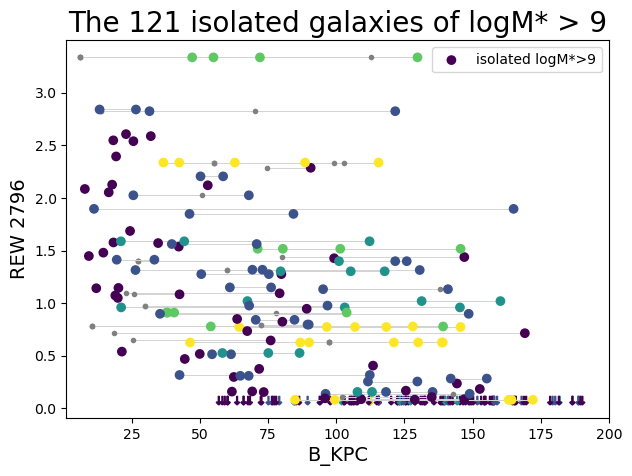

In [32]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in in_isol_zselec_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(in_isol_zselec_abs["B_KPC"], in_isol_zselec_abs["REW_2796"], c = in_isol_zselec_abs["Nlos"],\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)

plt.scatter(in_isol_zselec_noabs["B_KPC"], in_isol_zselec_noabs["detection_limit_p75"], \
            c = in_isol_zselec_noabs["Nlos"], marker = "$\downarrow$", vmin = 1, vmax = 5)
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

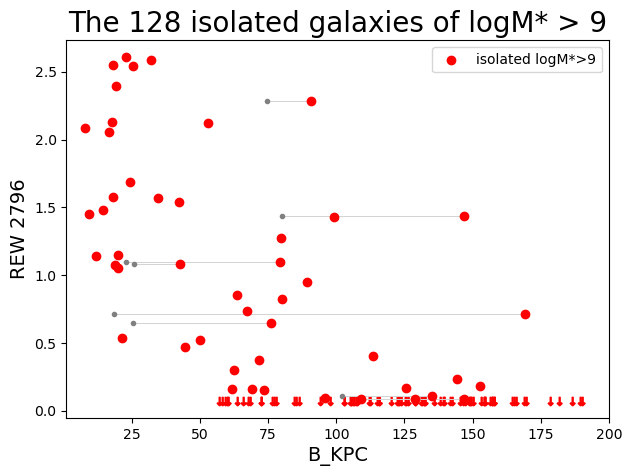

In [33]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_1)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_1.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_1_abs["B_KPC"], isol_1_abs["REW_2796"], c = "r",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)

plt.scatter(isol_1_noabs["B_KPC"], isol_1_noabs["detection_limit_p75"], \
            c = "r", marker = "$\downarrow$", vmin = 1, vmax = 5)
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

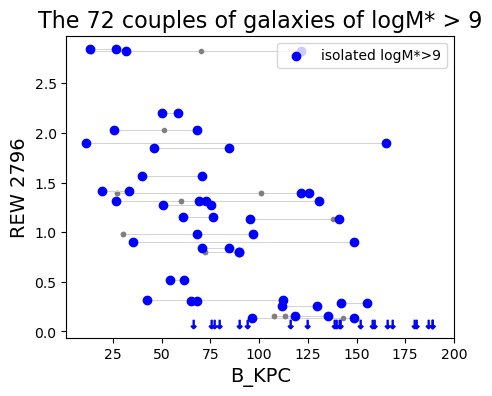

In [34]:
plt.figure(dpi = 100, figsize = (5, 4))
plt.title("The " + str(len(isol_2)) + " couples of galaxies of logM* > 9", size = 16)

dv = 0.5e6
for i, g in isol_2.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_2_abs["B_KPC"], isol_2_abs["REW_2796"], c = "b",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)

plt.scatter(isol_2_noabs["B_KPC"], isol_2_noabs["detection_limit_p75"], \
            c = "b", marker = "$\downarrow$", vmin = 1, vmax = 5)
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

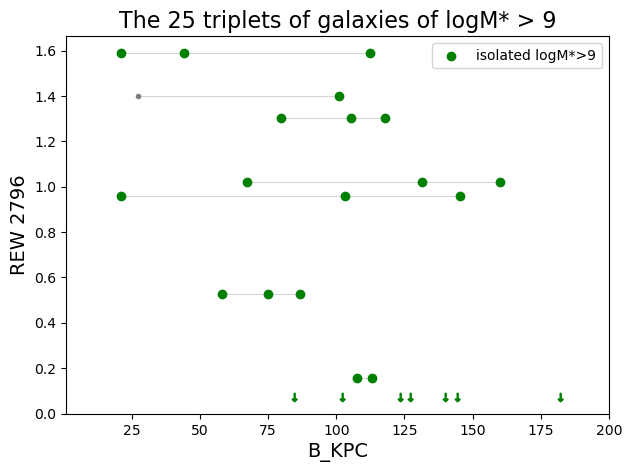

In [35]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_3)) + " triplets of galaxies of logM* > 9", size = 16)

dv = 0.5e6
for i, g in isol_3.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_3_abs["B_KPC"], isol_3_abs["REW_2796"], c = "g",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)

plt.scatter(isol_3_noabs["B_KPC"], isol_3_noabs["detection_limit_p75"], \
            c = "g", marker = "$\downarrow$", vmin = 1, vmax = 5)
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

In [36]:
isol_3_abs[["field_id", "ID", "Z", "B_KPC", "ZCONF", "isolation_dist", "Nlos", "abs_id", "REW_2796"]]

,field_id,ID,Z,B_KPC,ZCONF,isolation_dist,Nlos,abs_id,REW_2796
693,J0134p0051,17086,0.40274,107.76,3,208.928832,3,141,0.157
708,J0134p0051,17101,0.40075,113.11,3,209.157510,3,141,0.157
793,J0800p1849,19005,0.84323,103.09,3,166.906915,3,29,0.960
835,J0800p1849,19073,0.84331,21.08,3,166.900631,3,29,0.960
842,J0800p1849,19080,0.60688,160.21,3,187.460913,3,28,1.020
855,J0800p1849,19093,0.60601,131.31,3,187.544533,3,28,1.020
866,J0800p1849,19104,0.84295,145.36,3,166.928914,3,29,0.960
867,J0800p1849,19105,0.60800,67.41,2,187.353357,3,28,1.020
1214,J1107p1021,23112,1.29556,58.22,3,137.121196,3,50,0.527
1217,J1107p1021,23115,1.29566,86.53,3,137.115698,3,50,0.527


In [37]:
f1 = np.abs(R["Z"] - 1.13689)*const.c.value/(1+1.13689) < 0.5e6
f2 = R["field_id"] == "J1352p0614"
f4 = R["B_KPC"] <= 146.4
f5 = R["sed_logMass"] > 9
KK = R[f1 & f2 & f4 & f5]

In [38]:
len(KK)

3

In [39]:
KK[["ID", "Z", "ZCONF", "sed_logMass", "B_KPC", "Nlos"]]

,ID,Z,ZCONF,sed_logMass,B_KPC,Nlos
1524,27045,1.13582,3,10.027198,121.62,2
1528,27049,1.13689,3,11.773106,100.99,3
1538,27060,1.14022,3,10.611500,125.84,2


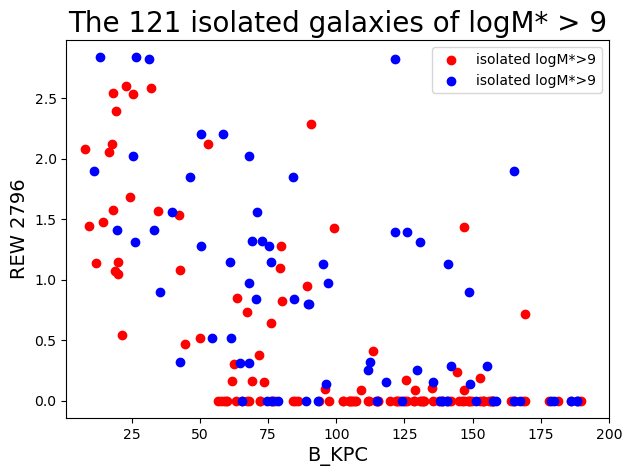

In [40]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

plt.scatter(isol_1["B_KPC"], isol_1["REW_2796"], c = "r",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)

plt.scatter(isol_2["B_KPC"], isol_2["REW_2796"], c = "b",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)

#plt.scatter(isol_3["B_KPC"], isol_3["REW_2796"], c = "g",\
#                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)


#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

Text(0, 0.5, 'REW 2796')

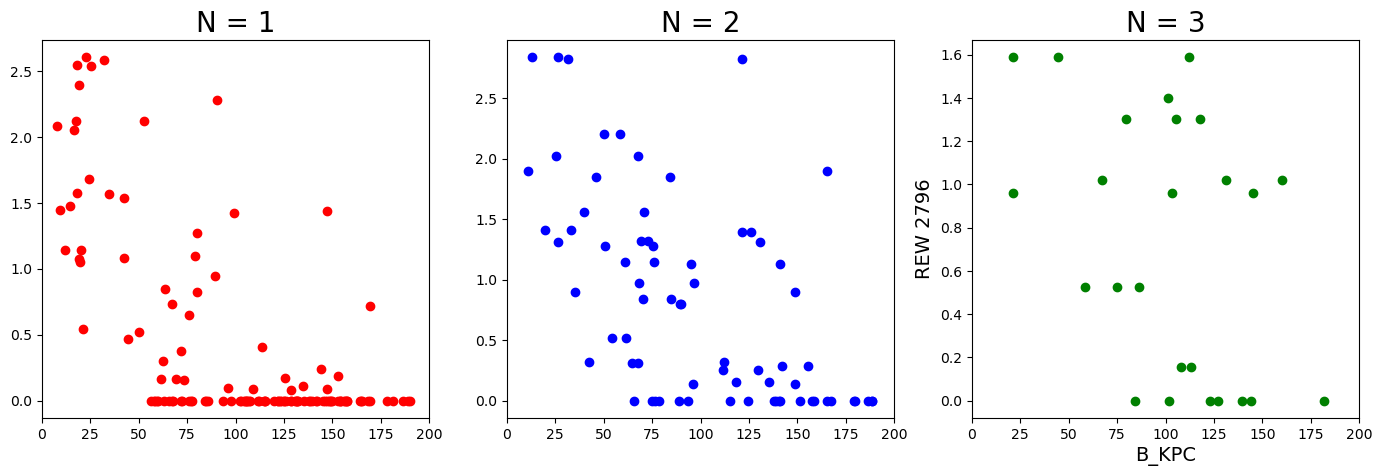

In [41]:
plt.figure(dpi = 100, figsize = (17, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)
plt.subplot(131)
plt.title("N = 1", size = 20)
plt.scatter(isol_1["B_KPC"], isol_1["REW_2796"], c = "r",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)
plt.xlim((0, 200))

plt.subplot(132)
plt.title("N = 2", size = 20)
plt.scatter(isol_2["B_KPC"], isol_2["REW_2796"], c = "b",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)
plt.xlim((0, 200))

plt.subplot(133)
plt.title("N = 3", size = 20)
plt.scatter(isol_3["B_KPC"], isol_3["REW_2796"], c = "g",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)
plt.xlim((0, 200))


#plt.colorbar(label = "N2000")

#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)

Text(0, 0.5, 'REW 2796')

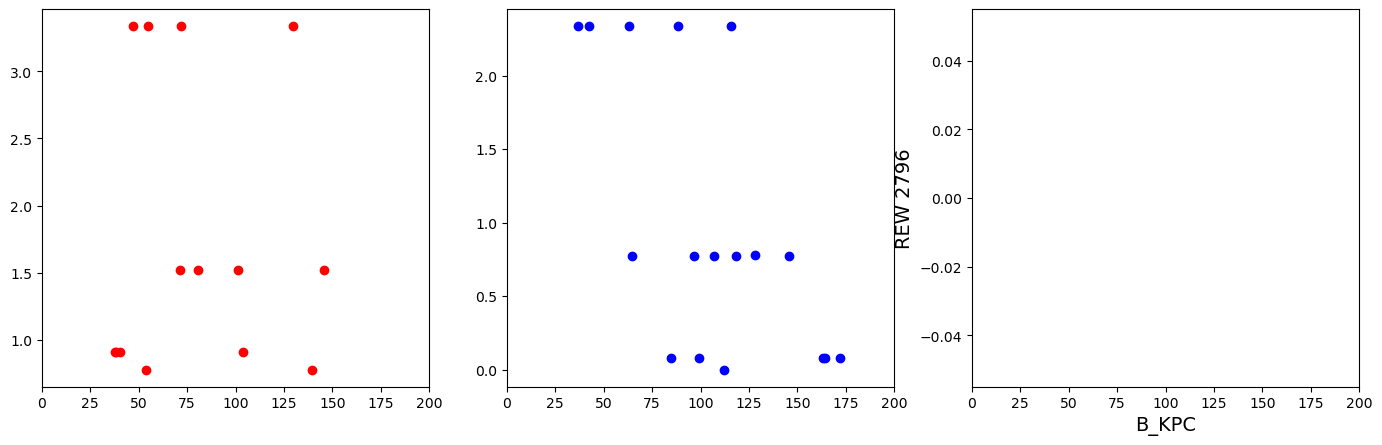

In [42]:
plt.figure(dpi = 100, figsize = (17, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)
plt.subplot(131)
plt.scatter(isol_4["B_KPC"], isol_4["REW_2796"], c = "r",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)
plt.xlim((0, 200))

plt.subplot(132)
plt.scatter(isol_5["B_KPC"], isol_5["REW_2796"], c = "b",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)
plt.xlim((0, 200))

plt.subplot(133)
plt.scatter(isol_6["B_KPC"], isol_6["REW_2796"], c = "g",\
                 label = "isolated logM*>9", zorder = 2, vmin = 1, vmax = 5)
plt.xlim((0, 200))


#plt.colorbar(label = "N2000")

#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)

In [43]:
isol_3[["field_id", "ID", "Z", "B_KPC", "abs_id", "Nlos", "sed_logMass"]]

,field_id,ID,Z,B_KPC,abs_id,Nlos,sed_logMass
693,J0134p0051,17086,0.40274,107.76,141,3,9.007995
708,J0134p0051,17101,0.40075,113.11,141,3,10.576167
793,J0800p1849,19005,0.84323,103.09,29,3,9.921810
835,J0800p1849,19073,0.84331,21.08,29,3,9.594076
842,J0800p1849,19080,0.60688,160.21,28,3,9.583120
855,J0800p1849,19093,0.60601,131.31,28,3,11.133873
866,J0800p1849,19104,0.84295,145.36,29,3,9.653000
867,J0800p1849,19105,0.60800,67.41,28,3,10.593911
1214,J1107p1021,23112,1.29556,58.22,50,3,9.056438
1217,J1107p1021,23115,1.29566,86.53,50,3,9.547503


# Disk - halo decomposition

In [272]:
R = pd.read_csv("results_decomp_1.csv")

In [273]:
Q = R[R["run_name"] == "run_OII_decomp"]
len(Q)

300

In [274]:
fzlow_04 = R["Z"] > 0.4
fzlow_05 = R["Z"] > 0.5
fzhigh_15 = R["Z"] < 1.5
fzconf_0 = R["ZCONF"] > 0
fzconf_1 = R["ZCONF"] > 1
fnoQSO = R["is_QSO"] == 0
fnostar = R["is_star"] == 0

In [275]:
R_lowz = R[fzhigh_15 & fzconf_0 & fnoQSO & fnostar]
R_goodz_goodconf = R[fzlow_04 & fzhigh_15 & fzconf_1 & fnoQSO & fnostar]

print("Number of galaxies at z below 1.5 = ", len(R_lowz))
print("Number of galaxies at z below 1.5  and zconf= 2 or more = ", len(R_goodz_goodconf))

Number of galaxies at z below 1.5 =  1262
Number of galaxies at z below 1.5  and zconf= 2 or more =  960


In [276]:
R_lowz = isolated_auto_modif3(R_lowz, Mh = 1e12, b_sep = 20, dv = 0.5e6, group_threshold = 4, logm_sat = 9)

In [277]:
R = R_lowz.copy()
print(len(R))

1262


In [278]:
R.loc[R["ID"] == 14113, "bool_absorption"] = 0
R.loc[R["ID"] == 14113, "REW_2796"] = 0

In [279]:
f2 = R["N100_neighb"]<= 1
f100 = R["B_KPC"] <= 100
f150 = R["B_KPC"] <= 150
f200 = R["B_KPC"] <= 200
f4 = R["REW_2796"]>=0.3
f5 = R["REW_2796"]>=0.01
f6 = R["inclination_convergence"] == 1
f7 = R["pa_convergence"] == 1
f8 = R["snr_eff"]>=3
f9 = R["snr_eff"]>=10
f10 = R["inclination"] >= 40 
f11 = R["inclination"] >= 60
f12 = R["N100_abs"] == 1
f13 = R["N100_abs"] <= 2
f14 = R["bool_absorption"] == 1
f15 = R["N100_neighb"]<= 1
f16 = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 3000 #from Zabl 2019
f16b = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 1500 #from Zabl 2019
f17 = R["N50_neighb"]== 0
f18 = R["N50_neighb"]<= 1
f19 = R["alpha"] <= 40
f20 = R["is_QSO"] == 0
f21 = R["N2000_abs"] <= 4
f22 = R["is_closest"] == 1
f23 = R["B_KPC_NEIGHB"] >= 30
f24 = R["Z"] < 2
fzlow = R["Z"] > 0.4
fzhigh = R["Z"] < 1.5
fzconf_1 = R["ZCONF"] > 1
f25 = R["N2000_LOS"] <= 4
f26 = R["is_star"] == 0
f27_1 = R["alpha"] <= 33
f27_2 = (R["alpha"] >= 33) & (R["alpha"] <= 66)
f27_3 = R["alpha"] >= 66
f28 = R["inclination"] >= 35
#f29 = R["current"] == 1
f30 = R["isolated_auto"] == 1
f31 = R["primary_auto"] == 1
#f32 = R["galpak_score"] != 0
f33 = R["score_auto"] >= 1
f34 = R["score_auto"] >= 2
f35 = R["score_auto"] >= 3
f36 = R["sed_logMass"] >= 9
#f37 = R["run_convergence_global"] >= 0.99
f38 = R["ID"].isin(bad_runs_ids)
f39 = R["sed_logMass"].isna()
f_SFR1 = np.log10(R["SFR_gilbank"]) >= 0
f_SFR01 = np.log10(R["SFR_gilbank"]) >= 0
f40 = (R["OII3726_FLUX"] + R["OII3729_FLUX"]) >= 300
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)

In [280]:
prim = R[f20 & f31]
R_9 = R[f20 & f100 & fzlow & fzhigh & fzconf_1 & fbehind & f36]
R100 = R[f20 & fzlow & fzhigh & fbehind & f100] 
R150 = R[f20 & fzlow & fzhigh & fbehind & f150]
R200 = R[f20 & fzlow & fzhigh & fbehind & f200]

isol = R[f20 & f30 & fbehind] #isolated galaxies
isol_abs = R[f20 & f30 & f14 & fbehind]
isol_noabs = R[f20 & f30 & ~f14 & fbehind]
isol_zconf = R[f20 & f30 & fzconf_1 & fbehind]
isol_zconf_abs = R[f20 & f30 & fzconf_1 & f14 & fbehind]
isol_zconf_noabs = R[f20 & f30 & fzconf_1 & ~f14 & fbehind]
isol_zselec = R[f20 &f30 & fzlow & fzhigh & fbehind] # isolated in z= 0.4 - 1.5
isol_zselec_mass = R[f20 & f30 & fzconf_1 & fzlow & fzhigh & fbehind & ~f39] 
isol_zselec_nomass = R[f20 & f30 & fzconf_1 & fzlow & fzhigh & fbehind & f39]
isol_zconf_1 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1
isol_9 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f14 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & ~f14 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_lowM = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & fbehind] # isolated with z = 0.4-1.5 and zconf = 1 and M* below 1e9
isol_lowM_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & f14 & fbehind]
isol_lowM_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & ~f14 & fbehind]
isol_9_convergence = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & fbehind] # idem with good convergence
isol_9_noconvergence = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & ~f37 & fbehind] # idem with good convergence
isol_lowM_convergence = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & f37 & fbehind]
isol_snr3 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & fbehind] # idem with good snr
isol_lowM_snr3 = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & ~f36 & f37 & f8 & fbehind]
isol_good_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & fbehind] # good runs
isol_notgood_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f38 & fbehind]
isol_good_runs_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & f14 & fbehind] # good runs
isol_good_runs_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & ~f38 & ~f14 & fbehind] # good runs
isol_incl_good_runs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind] # good runs
isol_incl_good_runs_abs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & f14 & fbehind] # good runs
isol_incl_good_runs_noabs = R[f20 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & ~f14 & fbehind] # good runs

isol_high_alpha = R[f20 & f10 & f27_3 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind]
isol_mid_alpha = R[f20 & f10 & f27_2 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind]
isol_low_alpha = R[f20 & f10 & f27_1 & f30 & fzlow & fzhigh & fzconf_1 & f36 & f37 & f8 & f10 & ~f38 & fbehind]

print("Number of galaxies with logM > 9, good z, QSO behind, good zconf = ", len(R_9))
print("Number of primaries = ", len(prim))
print("Number of isolated = ", len(isol))
print("Number of isolated with abs = ", len(isol_abs))
print("Number of distinct absorptions associated with isolated  = ", len(isol_abs["abs_id"].unique()))
print("Number of isolated with zconf >= 2 ", len(isol_zconf))
print("Number of isolated at 0.4 < z < 1.5 = ", len(isol_zselec))
print("Number of isolated at 0.4 < z < 1.5 and zconf >= 2 ", len(isol_zconf_1))
print("and with mass = ", len(isol_zselec_mass))
print("or without mass = ", len(isol_zselec_nomass))
print("with the previous filters on isolation, z, zconf and QSO behind:")
print("Number of isolated with logM > 9 = ", len(isol_9))
print("Number of isolated with logM > 9 and multinest run = ", len(isol_9[isol_9["run_name"] == "run_OII_multinest"]))
print("Number of isolated with logM > 9 with abs = ", len(isol_9_abs))
print("Number of isolated with logM > 9 without abs = ", len(isol_9_noabs))
print("Number of isolated with logM > 9 and good convergence = ", len(isol_9_convergence))
print("Number of isolated with logM > 9 and good convergence and snr_eff > 3  = ", len(isol_snr3))
print("Number of isolated with logM > 9 and good galpak runs  = ", len(isol_good_runs))
print("Number of isolated with logM > 9 and good galpak runs and incl>40 = ", len(isol_incl_good_runs))

Number of galaxies with logM > 9, good z, QSO behind, good zconf =  127
Number of primaries =  191
Number of isolated =  153
Number of isolated with abs =  44
Number of distinct absorptions associated with isolated  =  44
Number of isolated with zconf >= 2  140
Number of isolated at 0.4 < z < 1.5 =  132
Number of isolated at 0.4 < z < 1.5 and zconf >= 2  121
and with mass =  121
or without mass =  0
with the previous filters on isolation, z, zconf and QSO behind:
Number of isolated with logM > 9 =  121
Number of isolated with logM > 9 and multinest run =  0
Number of isolated with logM > 9 with abs =  43
Number of isolated with logM > 9 without abs =  78
Number of isolated with logM > 9 and good convergence =  119
Number of isolated with logM > 9 and good convergence and snr_eff > 3  =  89
Number of isolated with logM > 9 and good galpak runs  =  80
Number of isolated with logM > 9 and good galpak runs and incl>40 =  58


In [281]:
R_decomp = pd.read_csv("results_decomp_1.csv")
R_decomp.columns = R_decomp.columns + "_decomp"
R_decomp["ID"] = R_decomp["ID_decomp"]
R_decomp["field_id"] = R_decomp["field_id_decomp"]

In [282]:
compare = pd.merge(isol_good_runs_multinest, R_decomp, how="left", on=["field_id", "ID"])

In [289]:
len(compare)

82

Text(0, 0.5, 'Vvir decomposition')

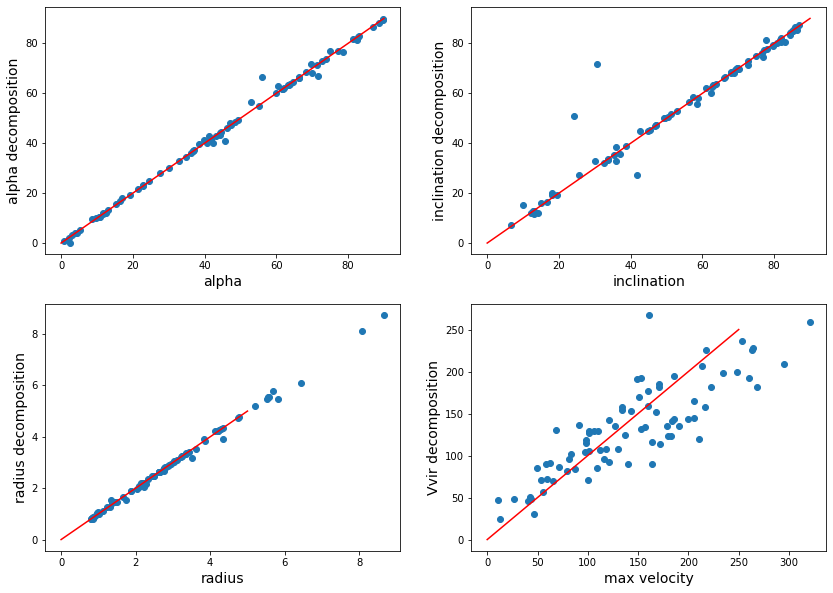

In [292]:
plt.figure(figsize = (14,10))
#plt.suptitle("The 82 good runs with SNR>3", size = 20)
plt.subplot(221)
plt.scatter(compare["alpha"], compare["alpha_decomp"])
plt.plot([0,90], [0,90], c = 'r')
plt.xlabel("alpha", size = 14)
plt.ylabel("alpha decomposition", size = 14)

plt.subplot(222)
plt.scatter(compare["inclination"], compare["inclination_decomp"])
plt.plot([0,90], [0,90], c = 'r')
plt.xlabel("inclination", size = 14)
plt.ylabel("inclination decomposition", size = 14)

plt.subplot(223)
plt.scatter(compare["radius"], compare["radius_decomp"])
plt.plot([0,5], [0,5], c = 'r')
plt.xlabel("radius", size = 14)
plt.ylabel("radius decomposition", size = 14)

plt.subplot(224)
plt.scatter(compare["maximum_velocity"], compare["virial_velocity_decomp"])
plt.plot([0,250], [0,250], c = 'r')
plt.xlabel("max velocity", size = 14)
plt.ylabel("Vvir decomposition", size = 14)

Text(0.5, 0, 'Rvir')

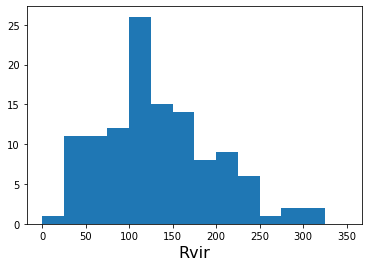

In [294]:
plt.hist(isol_9["Rvir"], range = (0,350), bins = 14);
plt.xlabel("Rvir", size = 16)

Text(0, 0.5, 'sed logM*')

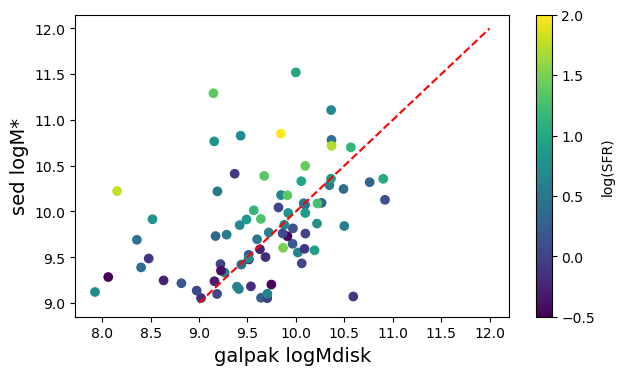

In [349]:
plt.figure(dpi = 100, figsize = (7, 4))
plt.scatter(isol_good_runs["log_Mdisk"], isol_good_runs["sed_logMass"], \
            c = np.log10(isol_good_runs["SFR_gilbank"]), vmin = -0.5, vmax = 2, \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.plot([9,12], [9,12], c = "r", linestyle = "--")
plt.colorbar(label = "log(SFR)")
plt.xlabel("galpak logMdisk", size = 14)
plt.ylabel("sed logM*", size = 14)

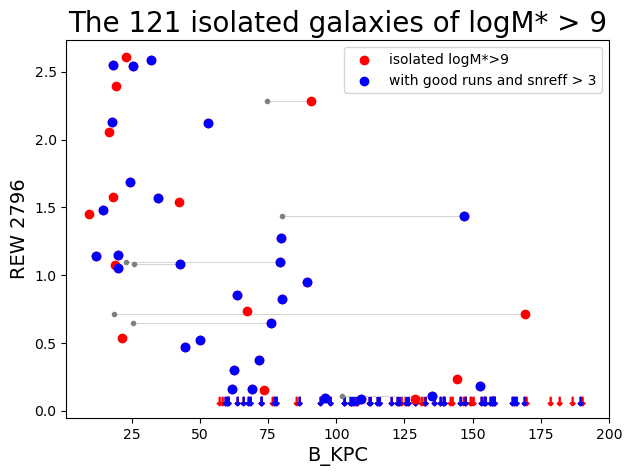

In [322]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_9)) + " isolated galaxies of logM* > 9", size = 20)

dv = 0.5e6
for i, g in isol_9_abs.iterrows():
    z_abs = g["z_absorption"]
    dz = dv*(1+z_abs)/const.c.value 
    k1 = np.abs(R_all["Z"] - z_abs) < dz
    k2 = R_all["field_id"] == g["field_id"]
    k3 = R_all["B_KPC"] <= g["B_KPC"]
    K = R_all[k1 & k2 & k3]
    bmin = np.min(K["B_KPC"])
    bmax = np.max(K["B_KPC"])
    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_9_abs["B_KPC"], isol_9_abs["REW_2796"], c = 'r',\
                 label = "isolated logM*>9", zorder = 2)

plt.scatter(isol_good_runs_abs["B_KPC"], isol_good_runs_abs["REW_2796"], c = 'b',\
                 label = "with good runs and snreff > 3", zorder = 3)

plt.scatter(isol_9_noabs["B_KPC"], isol_9_noabs["detection_limit_p75"], c = "r",\
             marker = "$\downarrow$")

plt.scatter(isol_good_runs_noabs["B_KPC"], isol_good_runs_noabs["detection_limit_p75"], c = "b",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B_KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

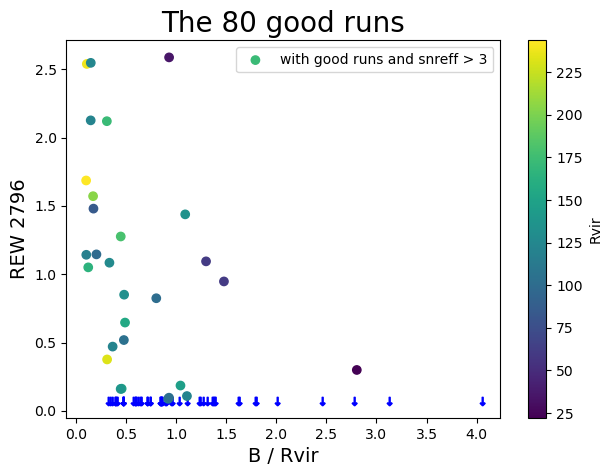

In [324]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_good_runs)) + " good runs", size = 20)

dv = 0.5e6
#for i, g in isol_9_abs.iterrows():
#    z_abs = g["z_absorption"]
#    dz = dv*(1+z_abs)/const.c.value 
#    k1 = np.abs(R_all["Z"] - z_abs) < dz
#    k2 = R_all["field_id"] == g["field_id"]
#    k3 = R_all["B_KPC"] <= g["B_KPC"]
#    K = R_all[k1 & k2 & k3]
#    bmin = np.min(K["B_KPC"])
#    bmax = np.max(K["B_KPC"])
#    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
#    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_good_runs_abs["B_KPC"]/isol_good_runs_abs["Rvir"], isol_good_runs_abs["REW_2796"],\
                 label = "with good runs and snreff > 3", zorder = 2, c = isol_good_runs_abs["Rvir"])
plt.colorbar(label = "Rvir")
plt.scatter(isol_good_runs_noabs["B_KPC"]/isol_good_runs_noabs["Rvir"],\
            isol_good_runs_noabs["detection_limit_p75"], c = "b",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
#plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B / Rvir", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

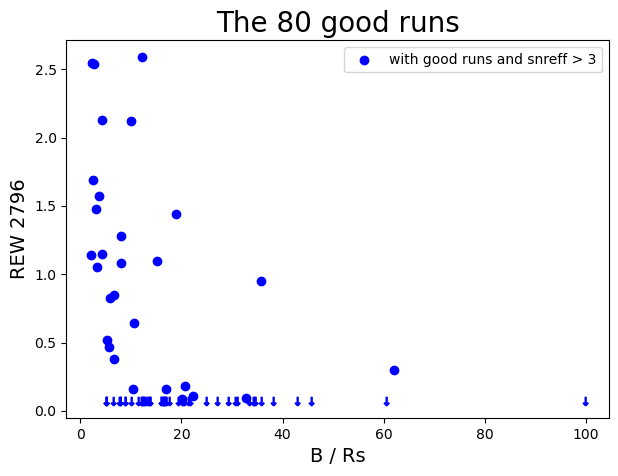

In [326]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_good_runs)) + " good runs", size = 20)

dv = 0.5e6
#for i, g in isol_9_abs.iterrows():
#    z_abs = g["z_absorption"]
#    dz = dv*(1+z_abs)/const.c.value 
#    k1 = np.abs(R_all["Z"] - z_abs) < dz
#    k2 = R_all["field_id"] == g["field_id"]
#    k3 = R_all["B_KPC"] <= g["B_KPC"]
#    K = R_all[k1 & k2 & k3]
#    bmin = np.min(K["B_KPC"])
#    bmax = np.max(K["B_KPC"])
#    plt.hlines(K["REW_2796"], bmin, bmax, color = "lightgray", linewidth = 0.6)
#    plt.scatter(K["B_KPC"], K["REW_2796"], marker = ".", c = "gray", zorder = 2)
    
plt.scatter(isol_good_runs_abs["B_KPC"]/isol_good_runs_abs["rs_kpc"], isol_good_runs_abs["REW_2796"], c = 'b',\
                 label = "with good runs and snreff > 3", zorder = 2)

plt.scatter(isol_good_runs_noabs["B_KPC"]/isol_good_runs_noabs["rs_kpc"],\
            isol_good_runs_noabs["detection_limit_p75"], c = "b",\
             marker = "$\downarrow$")
#plt.colorbar(label = "N2000")
#plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B / Rs", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

# Cusp / Core investigation

Text(0, 0.5, 'logSFR')

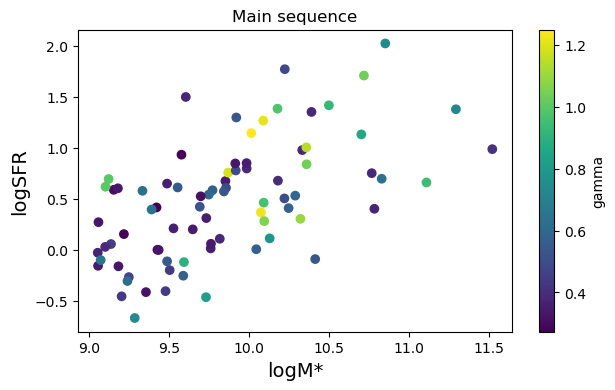

In [355]:
plt.figure(dpi = 100, figsize = (7, 4))
plt.title("Main sequence")
plt.scatter(isol_good_runs["sed_logMass"], np.log10(isol_good_runs["SFR_gilbank"]), \
            c = isol_good_runs["gamma"], \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.colorbar(label = "gamma")
plt.xlabel("logM*", size = 14)
plt.ylabel("logSFR", size = 14)

Text(0, 0.5, 'logSFR')

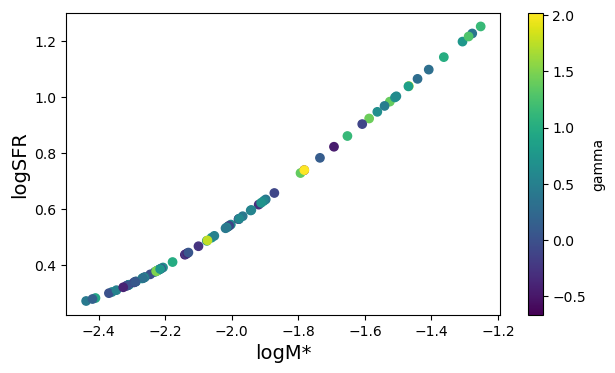

In [356]:
plt.figure(dpi = 100, figsize = (7, 4))
plt.scatter(isol_good_runs["log_X"], isol_good_runs["gamma"], \
            c = np.log10(isol_good_runs["SFR_gilbank"]), \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.colorbar(label = "gamma")
plt.xlabel("logM*", size = 14)
plt.ylabel("logSFR", size = 14)

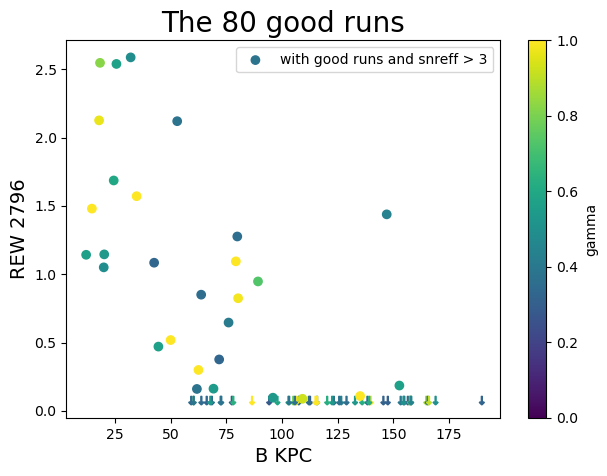

In [334]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_good_runs)) + " good runs", size = 20)

plt.scatter(isol_good_runs_abs["B_KPC"], isol_good_runs_abs["REW_2796"], \
            c = isol_good_runs_abs["gamma"], vmin = 0, vmax = 1, \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.colorbar(label = "gamma")
plt.scatter(isol_good_runs_noabs["B_KPC"],\
            isol_good_runs_noabs["detection_limit_p75"], c = isol_good_runs_noabs["gamma"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1)
#plt.colorbar(label = "N2000")
#plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B KPC", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

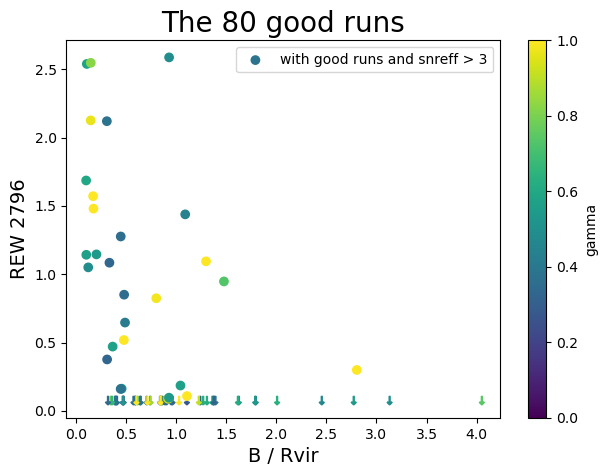

In [332]:
plt.figure(dpi = 100, figsize = (7, 5))
plt.title("The " + str(len(isol_good_runs)) + " good runs", size = 20)

plt.scatter(isol_good_runs_abs["B_KPC"]/isol_good_runs_abs["Rvir"], isol_good_runs_abs["REW_2796"], \
            c = isol_good_runs_abs["gamma"], vmin = 0, vmax = 1, \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.colorbar(label = "gamma")
plt.scatter(isol_good_runs_noabs["B_KPC"]/isol_good_runs_noabs["Rvir"],\
            isol_good_runs_noabs["detection_limit_p75"], c = isol_good_runs_noabs["gamma"],\
             marker = "$\downarrow$", vmin = 0, vmax = 1)
#plt.colorbar(label = "N2000")
#plt.xlim((1, 200))
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("B / Rvir", size = 14)
plt.ylabel("REW 2796", size = 14)
plt.legend()

Text(0, 0.5, 'gamma (inner slope)')

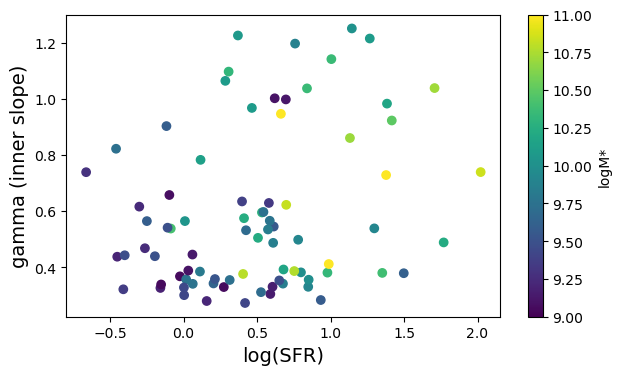

In [342]:
plt.figure(dpi = 100, figsize = (7, 4))
plt.scatter(np.log10(isol_good_runs["SFR_gilbank"]), isol_good_runs["gamma"], \
            c = isol_good_runs["sed_logMass"], vmin = 9, vmax = 11, \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.colorbar(label = "logM*")
plt.xlabel("log(SFR)", size = 14)
plt.ylabel("gamma (inner slope)", size = 14)

Text(0, 0.5, 'gamma (inner slope)')

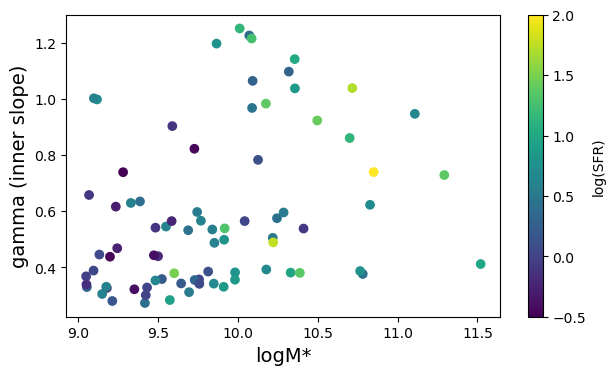

In [346]:
plt.figure(dpi = 100, figsize = (7, 4))
plt.scatter(isol_good_runs["sed_logMass"], isol_good_runs["gamma"], \
            c = np.log10(isol_good_runs["SFR_gilbank"]), vmin = -0.5, vmax = 2, \
                 label = "with good runs and snreff > 3", zorder = 2)
plt.colorbar(label = "log(SFR)")
plt.xlabel("logM*", size = 14)
plt.ylabel("gamma (inner slope)", size = 14)

In [316]:
for c in isol_good_runs.columns:
    print(c)

Unnamed: 0
ID
field_id
DATASET
FROM
Z
ZCONF
is_QSO
is_star
DR1_id
DR1_nbmatch
RA
DEC
B_KPC
B_ARCSEC
REFSPEC
REFCENTER
FELINE_ID
WHITE_ID
WHITE_ID.1
MANUAL_ID
fel_ID
FEL_score
FEL_sigma
WHITE_ID.2
WHITE_ID.3
wh_SDSS_r
wh_SDSS_i
sp_F775W
sp_SDSS_r
sp_SDSS_i
SDSS_r
SDSS_r_ERR
SDSS_i
SDSS_i_ERR
MAG_F775W
MAG_F775W_ERR
OII3726_FLUX
OII3726_FLUX_ERR
OII3726_EQW
OII3726_FLUX_EQW
OII3729_FLUX
OII3729_FLUX_ERR
OII3729_EQW
OII3729_EQW_ERR
MGII2796_EMI_FLUX
MGII2796_EMI_FLUX_ERR
MGII2796_ABS_EQW
MGII2796_ABS_EQW_ERR
MGII2803_EMI_FLUX
MGII2803_EMI_FLUX_ERR
MGII2803_ABS_EQW
MGII2803_ABS_EQW_ERR
sed_logMass
sed_logMass_l95
sed_logMass_u95
sed_rchisq
sed_ebv
sed_ebv_l95
sed_ebv_u95
sed_age
sed_age_l95
sed_age_u95
sed_metallicity
sed_tau
sed_tau_l95
sed_tau_u95
sed_curr_sfr
sed_curr_sfr_l95
sed_curr_sfr_u95
sed_sfr_100
sed_sfr_100_l95
sed_sfr_100_u95
photoz_zbest
photoz_zbest_l95
photoz_zbest_u95
photoz_rchisq
EXPTIME(s)
PSF_qso
Comments_qso
zqso_sdss
depth_qso
ebv_sfd_qso
ebv_sandf_qso
ebv_planck_qso

Text(0, 0.5, 'log(SFR/[M$_\\odot$ yr$^{-1}$])')

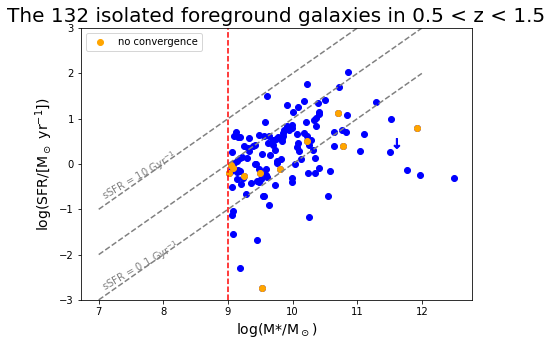

In [29]:
k1 = np.log10(isol_zselec["SFR_gilbank"]) < -3
plt.figure(figsize = (7,5))
isol_noSFR = isol_zselec[k1]

logmm = np.array([7,12])
sSFR_1 = np.log10(1e-9*10**logmm)
sSFR_01 = np.log10(0.1e-9*10**logmm)
sSFR_10 = np.log10(1e-8*10**logmm)


#sSFR = SFR/M
#SFR = M*sSFR
plt.title("The " + str(len(isol_zselec)) + " isolated foreground galaxies in 0.5 < z < 1.5", size = 20)

plt.scatter(isol_zselec["sed_logMass"], np.log10(isol_zselec["SFR_gilbank"]), c = "blue")
plt.scatter(isol_noSFR["sed_logMass"], np.log10(isol_noSFR["SFR_gilbank_lim"]), marker = "$\downarrow$",\
            s = 100, c = "blue")
plt.scatter(isol_9_noconvergence["sed_logMass"], np.log10(isol_9_noconvergence["SFR_gilbank"]), c = "orange",\
            label = "no convergence")
plt.plot(logmm, sSFR_01, c = 'grey', linestyle = "--")
plt.plot(logmm, sSFR_1, c = 'grey', linestyle = "--")
plt.plot(logmm, sSFR_10, c = 'grey', linestyle = "--")


plt.text(7, -0.8, 'sSFR = 10 Gyr$^{-1}$', fontsize = 10, color = 'gray', rotation = 30)
plt.text(7, -2.8, 'sSFR = 0.1 Gyr$^{-1}$', fontsize = 10, color = 'gray', rotation = 30)

plt.axvline(9, c = "r", linestyle = "--")

plt.legend()
plt.ylim((-3,3))
plt.xlabel("log(M*/M$_\odot$)", size = 14)
plt.ylabel("log(SFR/[M$_\odot$ yr$^{-1}$])", size = 14)

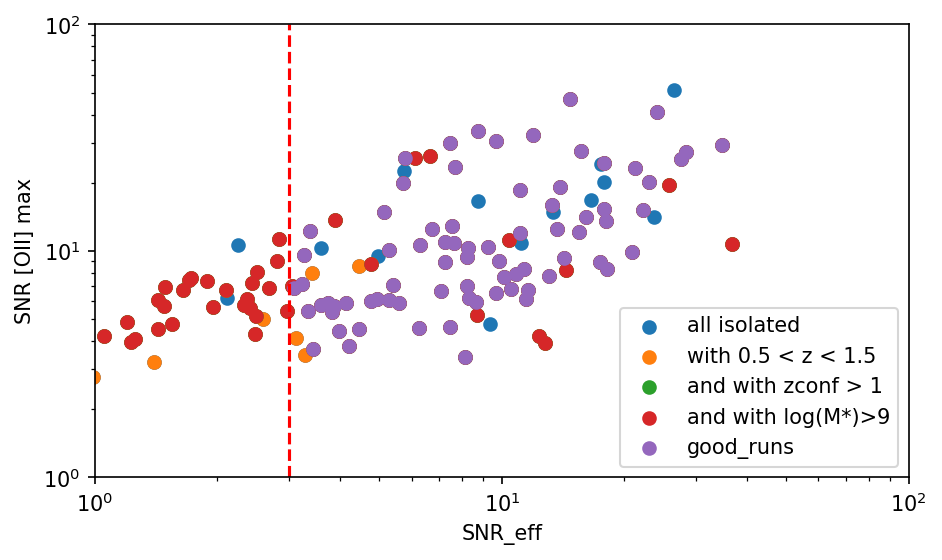

In [30]:
plt.figure(figsize =(7,4), dpi = 150)
plt.scatter(isol["snr_eff"], isol["snr_max"], label = "all isolated")
plt.scatter(isol_zselec["snr_eff"], isol_zselec["snr_max"], label = "with 0.5 < z < 1.5")
plt.scatter(isol_zconf_1["snr_eff"], isol_zconf_1["snr_max"], label = "and with zconf > 1")
plt.scatter(isol_9["snr_eff"], isol_9["snr_max"], label = "and with log(M*)>9")
plt.scatter(isol_good_runs["snr_eff"], isol_good_runs["snr_max"], label = "good_runs")
plt.axvline(3, color = "r", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlim((1, 100))
plt.ylim((1, 100))
plt.xlabel("SNR_eff")
plt.ylabel("SNR [OII] max")
plt.legend()

Text(0, 0.5, 'SNR [OII] max')

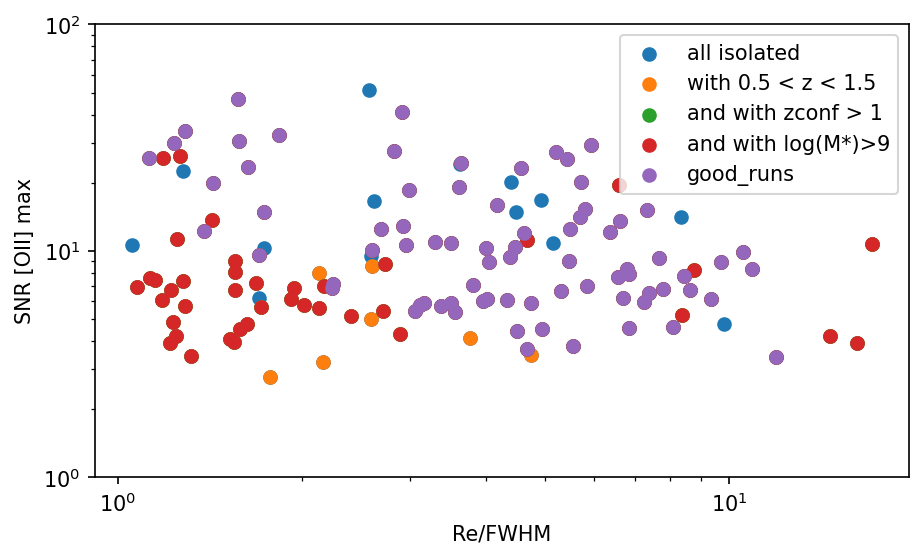

In [31]:
plt.figure(figsize =(7,4), dpi = 150)
plt.scatter(isol["radius"]/isol["psf_fwhm"], isol["snr_max"], label = "all isolated")
plt.scatter(isol_zselec["radius"]/isol_zselec["psf_fwhm"], isol_zselec["snr_max"], label = "with 0.5 < z < 1.5")
plt.scatter(isol_zconf_1["radius"]/isol_zconf_1["psf_fwhm"], isol_zconf_1["snr_max"], label = "and with zconf > 1")
plt.scatter(isol_9["radius"]/isol_9["psf_fwhm"], isol_9["snr_max"], label = "and with log(M*)>9")
plt.scatter(isol_good_runs["radius"]/isol_good_runs["psf_fwhm"], isol_good_runs["snr_max"], label = "good_runs")
plt.legend()
#plt.scatter(isol["radius"]/isol["psf_fwhm"], isol["snr_max"])
#plt.scatter(isol_9["radius"]/isol_9["psf_fwhm"], isol_9["snr_max"])
#plt.axvline(3, color = "r", linestyle = "--")
plt.xscale("log")
plt.yscale("log")
#plt.xlim((0.5, 1))
plt.ylim((1, 100))
plt.xlabel("Re/FWHM")
plt.ylabel("SNR [OII] max")

In [102]:
input_path = "/muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/"
output_path = "/muse/MG2QSO/private/analysis/galpak_dr2/"
gt.build_velocity_map_on_ids(input_path, output_path, isol_9, snr_min=1, ssmooth = 2)


1 / 121
J0014m0028_source-11083 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0014m0028/products/sources/J0014m0028_source-11083.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11083/
SKIP job: folder already exists

2 / 121
J0014m0028_source-11097 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0014m0028/products/sources/J0014m0028_source-11097.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11097/
SKIP job: folder already exists

3 / 121
J0014m0028_source-11117 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0014m0028/products/sources/J0014m0028_source-11117.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11117/
SKIP job: folder already exists

4 / 121
J0014m0028_source-11121 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0014m0028/products/sources/J0014m0028_source-11121.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0014m0028/J0014m0028_source-11121/
SKIP job: folder already exists

5 / 121
J0014m0028_source-1

SKIP job: folder already exists

35 / 121
J0134p0051_source-17035 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17035.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17035/
SKIP job: folder already exists

36 / 121
J0134p0051_source-17056 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17056.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17056/
Z =  0.6243256565051676  OII SNR =  8.105552362849108 24.2584050954114
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17056/J0134p0051_source-17056_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17056/J0134p0051_source-17056_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17056/camel_OII/camel_17056_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17056/camel_OII/camel_17056_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17056/J0134p0051_source-17056_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17056/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.7095355e-04
 2.7095355e-04 2.7095355e-04 2.7095355e-04 2.7095355e-04 2.7095355e-04
 2.7095355e-04 2.7095355e-04 2.7095355e-04 2.7095355e-04 2.7095355e-04
 2.7095355e-04 2.7095355e-04 2.7095355e-04 2.7095355e-04 2.7095355e-04
 2.7095355e-04 2.7095355e-04 2.7095355e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
37 / 121
J0134p0051_source-17066 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17066.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17066/
SKIP job: folder already exists

38 / 121
J0134p0051_source-17068 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17068.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17068/
Z =  1.2738838912160313  OII SNR =  5.589354941852932 3.066384479665708
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17068/J0134p0051_source-17068_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17068/J0134p0051_source-17068_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17068/camel_OII/camel_17068_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17068/camel_OII/camel_17068_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17068/J0134p0051_source-17068_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17068/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.7930626e-04
 3.7930626e-04 3.7930626e-04 3.7930626e-04 3.7930626e-04 3.7930626e-04
 3.7930626e-04 3.7930626e-04 3.7930626e-04 3.7930626e-04 3.7930626e-04
 3.7930626e-04 3.7930626e-04 3.7930626e-04 3.7930626e-04 3.7930626e-04
 3.7930626e-04 3.7930626e-04 3.7930626e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
39 / 121
J0134p0051_source-17072 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17072.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17072/
Z =  0.8204597746459383  OII SNR =  7.787689944393904e-09 2.5006025633945295
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17072/J0134p0051_source-17072_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17072/J0134p0051_source-17072_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17072/camel_OII/camel_17072_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17072/camel_OII/camel_17072_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17072/J0134p0051_source-17072_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17072/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.0367065e-04
 3.0367065e-04 3.0367065e-04 3.0367065e-04 3.0367065e-04 3.0367065e-04
 3.0367065e-04 3.0367065e-04 3.0367065e-04 3.0367065e-04 3.0367065e-04
 3.0367065e-04 3.0367065e-04 3.0367065e-04 3.0367065e-04 3.0367065e-04
 3.0367065e-04 3.0367065e-04 3.0367065e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
40 / 121
J0134p0051_source-17073 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17073.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17073/
Z =  0.5493053301884707  OII SNR =  12.1637034297972 15.54080341039456
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17073/J0134p0051_source-17073_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17073/J0134p0051_source-17073_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17073/camel_OII/camel_17073_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17073/camel_OII/camel_17073_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17073/J0134p0051_source-17073_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17073/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.5843942e-04
 2.5843942e-04 2.5843942e-04 2.5843942e-04 2.5843942e-04 2.5843942e-04
 2.5843942e-04 2.5843942e-04 2.5843942e-04 2.5843942e-04 2.5843942e-04
 2.5843942e-04 2.5843942e-04 2.5843942e-04 2.5843942e-04 2.5843942e-04
 2.5843942e-04 2.5843942e-04 2.5843942e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
41 / 121
J0134p0051_source-17078 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17078.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17078/
Z =  1.152612361944307  OII SNR =  4.7407797044475295 5.2595573350206495
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17078/J0134p0051_source-17078_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17078/J0134p0051_source-17078_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17078/camel_OII/camel_17078_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17078/camel_OII/camel_17078_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17078/J0134p0051_source-17078_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17078/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.5907698e-04
 3.5907698e-04 3.5907698e-04 3.5907698e-04 3.5907698e-04 3.5907698e-04
 3.5907698e-04 3.5907698e-04 3.5907698e-04 3.5907698e-04 3.5907698e-04
 3.5907698e-04 3.5907698e-04 3.5907698e-04 3.5907698e-04 3.5907698e-04
 3.5907698e-04 3.5907698e-04 3.5907698e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
42 / 121
J0134p0051_source-17080 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17080.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17080/
SKIP job: folder already exists

43 / 121
J0134p0051_source-17085 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17085.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17085/
Z =  0.9069270118196766  OII SNR =  4.718234286550704 6.536288199813875
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17085/J0134p0051_source-17085_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17085/J0134p0051_source-17085_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17085/camel_OII/camel_17085_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17085/camel_OII/camel_17085_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17085/J0134p0051_source-17085_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17085/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.1809424e-04
 3.1809424e-04 3.1809424e-04 3.1809424e-04 3.1809424e-04 3.1809424e-04
 3.1809424e-04 3.1809424e-04 3.1809424e-04 3.1809424e-04 3.1809424e-04
 3.1809424e-04 3.1809424e-04 3.1809424e-04 3.1809424e-04 3.1809424e-04
 3.1809424e-04 3.1809424e-04 3.1809424e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
44 / 121
J0134p0051_source-17102 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0134p0051/products/sources/J0134p0051_source-17102.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17102/
Z =  1.0494557988450057  OII SNR =  10.331648510390087 14.933050921705856
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17102/J0134p0051_source-17102_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17102/J0134p0051_source-17102_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17102/camel_OII/camel_17102_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17102/camel_OII/camel_17102_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17102/J0134p0051_source-17102_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0134p0051/J0134p0051_source-17102/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.4186945e-04
 3.4186945e-04 3.4186945e-04 3.4186945e-04 3.4186945e-04 3.4186945e-04
 3.4186945e-04 3.4186945e-04 3.4186945e-04 3.4186945e-04 3.4186945e-04
 3.4186945e-04 3.4186945e-04 3.4186945e-04 3.4186945e-04 3.4186945e-04
 3.4186945e-04 3.4186945e-04 3.4186945e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
45 / 121
J0145p1056_source-18049 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0145p1056/products/sources/J0145p1056_source-18049.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18049/
SKIP job: folder already exists

46 / 121
J0145p1056_source-18057 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0145p1056/products/sources/J0145p1056_source-18057.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18057/
Z =  0.5561446700661763  OII SNR =  11.57749102475491 13.446260269584572
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18057/J0145p1056_source-18057_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18057/J0145p1056_source-18057_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18057/camel_OII/camel_18057_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18057/camel_OII/camel_18057_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18057/J0145p1056_source-18057_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18057/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 2.595803e-04
 2.595803e-04 2.595803e-04 2.595803e-04 2.595803e-04 2.595803e-04
 2.595803e-04 2.595803e-04 2.595803e-04 2.595803e-04 2.595803e-04
 2.595803e-04 2.595803e-04 2.595803e-04 2.595803e-04 2.595803e-04
 2.595803e-04 2.595803e-04 2.595803e-04 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000

Progress =>  99%
47 / 121
J0145p1056_source-18063 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0145p1056/products/sources/J0145p1056_source-18063.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18063/
SKIP job: folder already exists

48 / 121
J0145p1056_source-18097 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0145p1056/products/sources/J0145p1056_source-18097.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18097/
Z =  0.4503058307458605  OII SNR =  14.30818213989088 19.80299085600116
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18097/J0145p1056_source-18097_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18097/J0145p1056_source-18097_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18097/camel_OII/camel_18097_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18097/camel_OII/camel_18097_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18097/J0145p1056_source-18097_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0145p1056/J0145p1056_source-18097/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.4192533e-04
 2.4192533e-04 2.4192533e-04 2.4192533e-04 2.4192533e-04 2.4192533e-04
 2.4192533e-04 2.4192533e-04 2.4192533e-04 2.4192533e-04 2.4192533e-04
 2.4192533e-04 2.4192533e-04 2.4192533e-04 2.4192533e-04 2.4192533e-04
 2.4192533e-04 2.4192533e-04 2.4192533e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
49 / 121
J0800p1849_source-19044 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0800p1849/products/sources/J0800p1849_source-19044.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19044/
Z =  0.5414187718818959  OII SNR =  3.017028799160395e-11 10.497966451586686
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19044/J0800p1849_source-19044_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19044/J0800p1849_source-19044_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19044/camel_OII/camel_19044_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19044/camel_OII/camel_19044_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19044/J0800p1849_source-19044_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19044/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.5712387e-04
 2.5712387e-04 2.5712387e-04 2.5712387e-04 2.5712387e-04 2.5712387e-04
 2.5712387e-04 2.5712387e-04 2.5712387e-04 2.5712387e-04 2.5712387e-04
 2.5712387e-04 2.5712387e-04 2.5712387e-04 2.5712387e-04 2.5712387e-04
 2.5712387e-04 2.5712387e-04 2.5712387e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
50 / 121
J0800p1849_source-19060 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0800p1849/products/sources/J0800p1849_source-19060.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19060/
Z =  0.5731902710988328  OII SNR =  37.261065320243986 46.43157324288884
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19060/J0800p1849_source-19060_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19060/J0800p1849_source-19060_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19060/camel_OII/camel_19060_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19060/camel_OII/camel_19060_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19060/J0800p1849_source-19060_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19060/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6242365e-04
 2.6242365e-04 2.6242365e-04 2.6242365e-04 2.6242365e-04 2.6242365e-04
 2.6242365e-04 2.6242365e-04 2.6242365e-04 2.6242365e-04 2.6242365e-04
 2.6242365e-04 2.6242365e-04 2.6242365e-04 2.6242365e-04 2.6242365e-04
 2.6242365e-04 2.6242365e-04 2.6242365e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
51 / 121
J0800p1849_source-19072 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0800p1849/products/sources/J0800p1849_source-19072.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19072/
Z =  0.5159009541194857  OII SNR =  10.2299405304229 14.411940084620522
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19072/J0800p1849_source-19072_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19072/J0800p1849_source-19072_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19072/camel_OII/camel_19072_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19072/camel_OII/camel_19072_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19072/J0800p1849_source-19072_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19072/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.5286723e-04
 2.5286723e-04 2.5286723e-04 2.5286723e-04 2.5286723e-04 2.5286723e-04
 2.5286723e-04 2.5286723e-04 2.5286723e-04 2.5286723e-04 2.5286723e-04
 2.5286723e-04 2.5286723e-04 2.5286723e-04 2.5286723e-04 2.5286723e-04
 2.5286723e-04 2.5286723e-04 2.5286723e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
52 / 121
J0800p1849_source-19103 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0800p1849/products/sources/J0800p1849_source-19103.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0800p1849/J0800p1849_source-19103/
SKIP job: folder already exists

53 / 121
J0838p0257_source-20044 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0838p0257/products/sources/J0838p0257_source-20044.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20044/
Z =  0.5323554072495573  OII SNR =  29.050931783889144 37.13574615524429
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20044/J0838p0257_source-20044_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20044/J0838p0257_source-20044_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20044/camel_OII/camel_20044_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20044/camel_OII/camel_20044_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20044/J0838p0257_source-20044_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20044/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.5561202e-04
 2.5561202e-04 2.5561202e-04 2.5561202e-04 2.5561202e-04 2.5561202e-04
 2.5561202e-04 2.5561202e-04 2.5561202e-04 2.5561202e-04 2.5561202e-04
 2.5561202e-04 2.5561202e-04 2.5561202e-04 2.5561202e-04 2.5561202e-04
 2.5561202e-04 2.5561202e-04 2.5561202e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
54 / 121
J0838p0257_source-20052 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0838p0257/products/sources/J0838p0257_source-20052.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20052/
SKIP job: folder already exists

55 / 121
J0838p0257_source-20064 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0838p0257/products/sources/J0838p0257_source-20064.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20064/
SKIP job: folder already exists

56 / 121
J0838p0257_source-20066 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0838p0257/products/sources/J0838p0257_source-20066.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20066/
SKIP job: folder already exists

57 / 121
J0838p0257_source-20073 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0838p0257/products/sources/J0838p0257_source-20073.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20073/
Z =  0.6993776276950481  OII SNR =  1.34

INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20073/J0838p0257_source-20073_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20073/J0838p0257_source-20073_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20073/camel_OII/camel_20073_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20073/camel_OII/camel_20073_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20073/J0838p0257_source-20073_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20073/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.8347297e-04
 2.8347297e-04 2.8347297e-04 2.8347297e-04 2.8347297e-04 2.8347297e-04
 2.8347297e-04 2.8347297e-04 2.8347297e-04 2.8347297e-04 2.8347297e-04
 2.8347297e-04 2.8347297e-04 2.8347297e-04 2.8347297e-04 2.8347297e-04
 2.8347297e-04 2.8347297e-04 2.8347297e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
58 / 121
J0838p0257_source-20074 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0838p0257/products/sources/J0838p0257_source-20074.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20074/
Z =  0.557573613326029  OII SNR =  3.4643970187995525 6.966402934822298
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20074/J0838p0257_source-20074_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20074/J0838p0257_source-20074_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20074/camel_OII/camel_20074_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20074/camel_OII/camel_20074_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20074/J0838p0257_source-20074_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20074/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.5981865e-04
 2.5981865e-04 2.5981865e-04 2.5981865e-04 2.5981865e-04 2.5981865e-04
 2.5981865e-04 2.5981865e-04 2.5981865e-04 2.5981865e-04 2.5981865e-04
 2.5981865e-04 2.5981865e-04 2.5981865e-04 2.5981865e-04 2.5981865e-04
 2.5981865e-04 2.5981865e-04 2.5981865e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
59 / 121
J0838p0257_source-20077 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0838p0257/products/sources/J0838p0257_source-20077.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0838p0257/J0838p0257_source-20077/
SKIP job: folder already exists

60 / 121
J0937p0656_source-21107 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0937p0656/products/sources/J0937p0656_source-21107.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21107/
Z =  0.6372818500824569  OII SNR =  5.882462707377714 12.472100657568529
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21107/J0937p0656_source-21107_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21107/J0937p0656_source-21107_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21107/camel_OII/camel_21107_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21107/camel_OII/camel_21107_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21107/J0937p0656_source-21107_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21107/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.7311477e-04
 2.7311477e-04 2.7311477e-04 2.7311477e-04 2.7311477e-04 2.7311477e-04
 2.7311477e-04 2.7311477e-04 2.7311477e-04 2.7311477e-04 2.7311477e-04
 2.7311477e-04 2.7311477e-04 2.7311477e-04 2.7311477e-04 2.7311477e-04
 2.7311477e-04 2.7311477e-04 2.7311477e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
61 / 121
J0937p0656_source-21111 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0937p0656/products/sources/J0937p0656_source-21111.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21111/
SKIP job: folder already exists

62 / 121
J0937p0656_source-21117 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0937p0656/products/sources/J0937p0656_source-21117.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21117/
SKIP job: folder already exists

63 / 121
J0937p0656_source-21122 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0937p0656/products/sources/J0937p0656_source-21122.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21122/
Z =  0.9337211739809126  OII SNR =  41.930702668221286 49.080458848388886
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21122/J0937p0656_source-21122_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21122/J0937p0656_source-21122_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21122/camel_OII/camel_21122_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21122/camel_OII/camel_21122_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21122/J0937p0656_source-21122_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21122/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.2256378e-04
 3.2256378e-04 3.2256378e-04 3.2256378e-04 3.2256378e-04 3.2256378e-04
 3.2256378e-04 3.2256378e-04 3.2256378e-04 3.2256378e-04 3.2256378e-04
 3.2256378e-04 3.2256378e-04 3.2256378e-04 3.2256378e-04 3.2256378e-04
 3.2256378e-04 3.2256378e-04 3.2256378e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
64 / 121
J0937p0656_source-21126 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0937p0656/products/sources/J0937p0656_source-21126.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21126/
SKIP job: folder already exists

65 / 121
J0937p0656_source-21127 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J0937p0656/products/sources/J0937p0656_source-21127.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J0937p0656/J0937p0656_source-21127/
SKIP job: folder already exists

66 / 121
J1039p0714_source-22044 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1039p0714/products/sources/J1039p0714_source-22044.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22044/
Z =  0.48419110183221403  OII SNR =  1.5241474801672963 3.615355643587156
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22044/J1039p0714_source-22044_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22044/J1039p0714_source-22044_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22044/camel_OII/camel_22044_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22044/camel_OII/camel_22044_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22044/J1039p0714_source-22044_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22044/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.4757773e-04
 2.4757773e-04 2.4757773e-04 2.4757773e-04 2.4757773e-04 2.4757773e-04
 2.4757773e-04 2.4757773e-04 2.4757773e-04 2.4757773e-04 2.4757773e-04
 2.4757773e-04 2.4757773e-04 2.4757773e-04 2.4757773e-04 2.4757773e-04
 2.4757773e-04 2.4757773e-04 2.4757773e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
67 / 121
J1039p0714_source-22047 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1039p0714/products/sources/J1039p0714_source-22047.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22047/
Z =  0.5116155743931956  OII SNR =  22.642380698238558 26.859928455523708
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22047/J1039p0714_source-22047_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22047/J1039p0714_source-22047_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22047/camel_OII/camel_22047_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22047/camel_OII/camel_22047_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22047/J1039p0714_source-22047_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22047/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 2.521524e-04
 2.521524e-04 2.521524e-04 2.521524e-04 2.521524e-04 2.521524e-04
 2.521524e-04 2.521524e-04 2.521524e-04 2.521524e-04 2.521524e-04
 2.521524e-04 2.521524e-04 2.521524e-04 2.521524e-04 2.521524e-04
 2.521524e-04 2.521524e-04 2.521524e-04 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000

Progress =>  99%
68 / 121
J1039p0714_source-22048 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1039p0714/products/sources/J1039p0714_source-22048.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22048/
SKIP job: folder already exists

69 / 121
J1039p0714_source-22066 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1039p0714/products/sources/J1039p0714_source-22066.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1039p0714/J1039p0714_source-22066/
SKIP job: folder already exists

70 / 121
J1107p1021_source-23086 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1021/products/sources/J1107p1021_source-23086.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23086/
SKIP job: folder already exists

71 / 121
J1107p1021_source-23089 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1021/products/sources/J1107p1021_source-23089.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23089/
Z =  0.6269678311417359  OII SNR =  14.1

INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23089/J1107p1021_source-23089_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23089/J1107p1021_source-23089_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23089/camel_OII/camel_23089_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23089/camel_OII/camel_23089_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23089/J1107p1021_source-23089_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23089/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 2.713943e-04
 2.713943e-04 2.713943e-04 2.713943e-04 2.713943e-04 2.713943e-04
 2.713943e-04 2.713943e-04 2.713943e-04 2.713943e-04 2.713943e-04
 2.713943e-04 2.713943e-04 2.713943e-04 2.713943e-04 2.713943e-04
 2.713943e-04 2.713943e-04 2.713943e-04 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000

/muse/MG2QSO/private/analysis/galpak_dr2/CAMEL/camel.py:1100: RuntimeWarning: invalid value encountered in true_divide
  perrorcube = perrorcube * np.sqrt(fnormmap / dofmap)
/muse/MG2QSO/private/analysis/galpak_dr2/CAMEL/camel.py:1124: RuntimeWarning: invalid value encountered in true_divide
  chi2map = fnormmap / dofmap
/muse/MG2QSO/private/analysis/galpak_dr2/CAMEL/camel.py:1167: RuntimeWarning: divide by zero encountered in true_divide
  fluxmaps[comp * els.index + i, :, :] = np.sum(intmaps[comp * els.index + i, :, :] * np.exp(-0.5 * (wave.reshape(wave.size, 1, 1) - linewave[i] * (1 + zmap[comp * els.index + i, :, :])) ** 2 / ((dzmap * linewave[i]) ** 2 + conf['SPSF'] ** 2)) * sclp * lconvfac, axis=0)
/muse/MG2QSO/private/analysis/galpak_dr2/CAMEL/camel.py:1176: RuntimeWarning: invalid value encountered in true_divide
  efluxmaps[comp * els.index + i, :, :] = np.sqrt(np.pi * 2) * np.sqrt((eintmaps[comp * els.index + i, :, :] * np.sqrt((linewave[i] * dzmap) ** 2 + conf['SPSF'] ** 2))


72 / 121
J1107p1021_source-23092 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1021/products/sources/J1107p1021_source-23092.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23092/
Z =  1.1086764932399396  OII SNR =  27.15793828814189 27.222995896814727
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23092/J1107p1021_source-23092_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23092/J1107p1021_source-23092_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23092/camel_OII/camel_23092_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23092/camel_OII/camel_23092_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23092/J1107p1021_source-23092_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23092/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.5174805e-04
 3.5174805e-04 3.5174805e-04 3.5174805e-04 3.5174805e-04 3.5174805e-04
 3.5174805e-04 3.5174805e-04 3.5174805e-04 3.5174805e-04 3.5174805e-04
 3.5174805e-04 3.5174805e-04 3.5174805e-04 3.5174805e-04 3.5174805e-04
 3.5174805e-04 3.5174805e-04 3.5174805e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

/muse/MG2QSO/private/analysis/galpak_dr2/galpak_tools.py:1612: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.imshow(img_vel*m, vmin = -150, vmax = 150, cmap = "bwr", extent = extent_kpc)



73 / 121
J1107p1021_source-23098 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1021/products/sources/J1107p1021_source-23098.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23098/
SKIP job: folder already exists

74 / 121
J1107p1021_source-23102 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1021/products/sources/J1107p1021_source-23102.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23102/
SKIP job: folder already exists

75 / 121
J1107p1021_source-23120 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1021/products/sources/J1107p1021_source-23120.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23120/
SKIP job: folder already exists

76 / 121
J1107p1021_source-23121 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1021/products/sources/J1107p1021_source-23121.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23121/
Z =  1.0347980869333222  OII SNR =  14.000094028607982 1

INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23121/J1107p1021_source-23121_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23121/J1107p1021_source-23121_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23121/camel_OII/camel_23121_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23121/camel_OII/camel_23121_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23121/J1107p1021_source-23121_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23121/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 3.394244e-04
 3.394244e-04 3.394244e-04 3.394244e-04 3.394244e-04 3.394244e-04
 3.394244e-04 3.394244e-04 3.394244e-04 3.394244e-04 3.394244e-04
 3.394244e-04 3.394244e-04 3.394244e-04 3.394244e-04 3.394244e-04
 3.394244e-04 3.394244e-04 3.394244e-04 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000

Progress =>  99%
77 / 121
J1107p1021_source-23122 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1021/products/sources/J1107p1021_source-23122.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1021/J1107p1021_source-23122/
SKIP job: folder already exists

78 / 121
J1107p1757_source-24036 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1757/products/sources/J1107p1757_source-24036.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24036/
Z =  0.7837018715983339  OII SNR =  12.068474486141438 15.784812564323445
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24036/J1107p1757_source-24036_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24036/J1107p1757_source-24036_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24036/camel_OII/camel_24036_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24036/camel_OII/camel_24036_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24036/J1107p1757_source-24036_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24036/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.9753908e-04
 2.9753908e-04 2.9753908e-04 2.9753908e-04 2.9753908e-04 2.9753908e-04
 2.9753908e-04 2.9753908e-04 2.9753908e-04 2.9753908e-04 2.9753908e-04
 2.9753908e-04 2.9753908e-04 2.9753908e-04 2.9753908e-04 2.9753908e-04
 2.9753908e-04 2.9753908e-04 2.9753908e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
79 / 121
J1107p1757_source-24038 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1757/products/sources/J1107p1757_source-24038.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24038/
Z =  1.3252558401987105  OII SNR =  1.0647827804294106e-09 1.49132868194516
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24038/J1107p1757_source-24038_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24038/J1107p1757_source-24038_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24038/camel_OII/camel_24038_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24038/camel_OII/camel_24038_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24038/J1107p1757_source-24038_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24038/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.8787563e-04
 3.8787563e-04 3.8787563e-04 3.8787563e-04 3.8787563e-04 3.8787563e-04
 3.8787563e-04 3.8787563e-04 3.8787563e-04 3.8787563e-04 3.8787563e-04
 3.8787563e-04 3.8787563e-04 3.8787563e-04 3.8787563e-04 3.8787563e-04
 3.8787563e-04 3.8787563e-04 3.8787563e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
80 / 121
J1107p1757_source-24043 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1757/products/sources/J1107p1757_source-24043.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24043/
Z =  0.9405979023291593  OII SNR =  7.189989339630425 5.962550023525321
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24043/J1107p1757_source-24043_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24043/J1107p1757_source-24043_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24043/camel_OII/camel_24043_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24043/camel_OII/camel_24043_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24043/J1107p1757_source-24043_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24043/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.2371088e-04
 3.2371088e-04 3.2371088e-04 3.2371088e-04 3.2371088e-04 3.2371088e-04
 3.2371088e-04 3.2371088e-04 3.2371088e-04 3.2371088e-04 3.2371088e-04
 3.2371088e-04 3.2371088e-04 3.2371088e-04 3.2371088e-04 3.2371088e-04
 3.2371088e-04 3.2371088e-04 3.2371088e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
81 / 121
J1107p1757_source-24044 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1757/products/sources/J1107p1757_source-24044.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24044/
SKIP job: folder already exists

82 / 121
J1107p1757_source-24052 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1757/products/sources/J1107p1757_source-24052.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24052/
SKIP job: folder already exists

83 / 121
J1107p1757_source-24053 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1107p1757/products/sources/J1107p1757_source-24053.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24053/
Z =  0.6542989558817398  OII SNR =  2.5699185107529274 5.3295088999172995
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24053/J1107p1757_source-24053_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24053/J1107p1757_source-24053_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24053/camel_OII/camel_24053_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24053/camel_OII/camel_24053_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24053/J1107p1757_source-24053_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1107p1757/J1107p1757_source-24053/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.7595338e-04
 2.7595338e-04 2.7595338e-04 2.7595338e-04 2.7595338e-04 2.7595338e-04
 2.7595338e-04 2.7595338e-04 2.7595338e-04 2.7595338e-04 2.7595338e-04
 2.7595338e-04 2.7595338e-04 2.7595338e-04 2.7595338e-04 2.7595338e-04
 2.7595338e-04 2.7595338e-04 2.7595338e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
84 / 121
J1236p0725_source-25070 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1236p0725/products/sources/J1236p0725_source-25070.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25070/
Z =  0.40417186381683723  OII SNR =  7.181319607064329 7.182512022037632
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25070/J1236p0725_source-25070_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25070/J1236p0725_source-25070_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25070/camel_OII/camel_25070_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25070/camel_OII/camel_25070_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25070/J1236p0725_source-25070_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25070/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.3422972e-04
 2.3422972e-04 2.3422972e-04 2.3422972e-04 2.3422972e-04 2.3422972e-04
 2.3422972e-04 2.3422972e-04 2.3422972e-04 2.3422972e-04 2.3422972e-04
 2.3422972e-04 2.3422972e-04 2.3422972e-04 2.3422972e-04 2.3422972e-04
 2.3422972e-04 2.3422972e-04 2.3422972e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

/muse/MG2QSO/private/analysis/galpak_dr2/CAMEL/camel.py:1100: RuntimeWarning: invalid value encountered in true_divide
  perrorcube = perrorcube * np.sqrt(fnormmap / dofmap)
/muse/MG2QSO/private/analysis/galpak_dr2/CAMEL/camel.py:1124: RuntimeWarning: invalid value encountered in true_divide
  chi2map = fnormmap / dofmap
/muse/MG2QSO/private/analysis/galpak_dr2/CAMEL/camel.py:1167: RuntimeWarning: divide by zero encountered in true_divide
  fluxmaps[comp * els.index + i, :, :] = np.sum(intmaps[comp * els.index + i, :, :] * np.exp(-0.5 * (wave.reshape(wave.size, 1, 1) - linewave[i] * (1 + zmap[comp * els.index + i, :, :])) ** 2 / ((dzmap * linewave[i]) ** 2 + conf['SPSF'] ** 2)) * sclp * lconvfac, axis=0)
/muse/MG2QSO/private/analysis/galpak_dr2/CAMEL/camel.py:1176: RuntimeWarning: invalid value encountered in true_divide
  efluxmaps[comp * els.index + i, :, :] = np.sqrt(np.pi * 2) * np.sqrt((eintmaps[comp * els.index + i, :, :] * np.sqrt((linewave[i] * dzmap) ** 2 + conf['SPSF'] ** 2))


85 / 121
J1236p0725_source-25087 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1236p0725/products/sources/J1236p0725_source-25087.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25087/
Z =  1.039851920494741  OII SNR =  4.397613676481636 5.572426696910609
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25087/J1236p0725_source-25087_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25087/J1236p0725_source-25087_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25087/camel_OII/camel_25087_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25087/camel_OII/camel_25087_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25087/J1236p0725_source-25087_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25087/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.4026743e-04
 3.4026743e-04 3.4026743e-04 3.4026743e-04 3.4026743e-04 3.4026743e-04
 3.4026743e-04 3.4026743e-04 3.4026743e-04 3.4026743e-04 3.4026743e-04
 3.4026743e-04 3.4026743e-04 3.4026743e-04 3.4026743e-04 3.4026743e-04
 3.4026743e-04 3.4026743e-04 3.4026743e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
86 / 121
J1236p0725_source-25095 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1236p0725/products/sources/J1236p0725_source-25095.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1236p0725/J1236p0725_source-25095/
SKIP job: folder already exists

87 / 121
J1314p0657_source-26056 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1314p0657/products/sources/J1314p0657_source-26056.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/J1314p0657_source-26056/
SKIP job: folder already exists

88 / 121
J1314p0657_source-26092 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1314p0657/products/sources/J1314p0657_source-26092.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/J1314p0657_source-26092/
Z =  1.2992865297006566  OII SNR =  6.581786724403898e-36 3.276723875241795e-33
before condition

89 / 121
J1314p0657_source-26095 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1314p0657/products/sources/J1314p0657_source-26095.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/

INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/J1314p0657_source-26095/J1314p0657_source-26095_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/J1314p0657_source-26095/J1314p0657_source-26095_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/J1314p0657_source-26095/camel_OII/camel_26095_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/J1314p0657_source-26095/camel_OII/camel_26095_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/J1314p0657_source-26095/J1314p0657_source-26095_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1314p0657/J1314p0657_source-26095/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.7271753e-04
 2.7271753e-04 2.7271753e-04 2.7271753e-04 2.7271753e-04 2.7271753e-04
 2.7271753e-04 2.7271753e-04 2.7271753e-04 2.7271753e-04 2.7271753e-04
 2.7271753e-04 2.7271753e-04 2.7271753e-04 2.7271753e-04 2.7271753e-04
 2.7271753e-04 2.7271753e-04 2.7271753e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
90 / 121
J1352p0614_source-27041 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1352p0614/products/sources/J1352p0614_source-27041.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27041/
Z =  0.5657445413666569  OII SNR =  26.003408039130086 35.836016388467534
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27041/J1352p0614_source-27041_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27041/J1352p0614_source-27041_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27041/camel_OII/camel_27041_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27041/camel_OII/camel_27041_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27041/J1352p0614_source-27041_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27041/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6118165e-04
 2.6118165e-04 2.6118165e-04 2.6118165e-04 2.6118165e-04 2.6118165e-04
 2.6118165e-04 2.6118165e-04 2.6118165e-04 2.6118165e-04 2.6118165e-04
 2.6118165e-04 2.6118165e-04 2.6118165e-04 2.6118165e-04 2.6118165e-04
 2.6118165e-04 2.6118165e-04 2.6118165e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
91 / 121
J1352p0614_source-27042 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1352p0614/products/sources/J1352p0614_source-27042.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27042/
Z =  0.4443032557041102  OII SNR =  23.96522087133996 36.70817766829081
before condition


INFO:CAMEL:Using cube /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27042/J1352p0614_source-27042_o2_cube.fits 
INFO:CAMEL:Using extension 1 of cube /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27042/J1352p0614_source-27042_o2_cube.fits 
INFO:CAMEL:Writing config /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27042/camel_OII/camel_27042_o2.config
INFO:CAMEL:Reading configuration file /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27042/camel_OII/camel_27042_o2.config
INFO:CAMEL:Reading data cube /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27042/J1352p0614_source-27042_o2_cube.fits and variance /muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27042/camel_OII/var_data.fits
INFO:CAMEL:Cutting data cube
INFO:CAMEL:Cutting variance
INFO:CAMEL:Variance cube contains NaN and has been corrected


creating the config file
running camel


INFO:CAMEL:Performing 10.0-sigma clipping using box of size 3. Number of pass: 3
INFO:CAMEL:Performing 2.0 pixels 2D gaussian spatial smoothing
INFO:CAMEL: Buildmaps: initial parameters [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.4092404e-04
 2.4092404e-04 2.4092404e-04 2.4092404e-04 2.4092404e-04 2.4092404e-04
 2.4092404e-04 2.4092404e-04 2.4092404e-04 2.4092404e-04 2.4092404e-04
 2.4092404e-04 2.4092404e-04 2.4092404e-04 2.4092404e-04 2.4092404e-04
 2.4092404e-04 2.4092404e-04 2.4092404e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.00

Progress =>  99%
92 / 121
J1352p0614_source-27066 /muse/MG2QSO/private/catalogs_dr2/dr2_vbeta/J1352p0614/products/sources/J1352p0614_source-27066.fits
/muse/MG2QSO/private/analysis/galpak_dr2/J1352p0614/J1352p0614_source-27066/


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

